In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
from scipy.integrate import quad, fixed_quad
import matplotlib.pyplot as plt
import pickle
import numpy as np
import functools
import sys
from tqdm import tqdm, trange
from aemulusnu_massfunction.utils import *
from aemulusnu_massfunction.emulator import *

from classy import Class

import math
import torch
import gpytorch
from matplotlib import pyplot as plt

import pyccl as ccl


In [3]:

cosmos_f = open('../data/cosmo_params.pkl', 'rb')
cosmo_params = pickle.load(cosmos_f) #cosmo_params is a dict
cosmos_f.close()

a_list_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/alist.pkl'
a_list_f = open(a_list_fname, 'rb')
a_list = pickle.load(a_list_f)
a_list_f.close()

In [4]:
weird_boxes = []


errors = {a:{} for a in a_list}
X = []
Y = []
z_to_a = {}
a_to_z = {}
kt = np.logspace(-3, 1, 100) # h/Mpc
for box in tqdm(cosmo_params):
    if(box in weird_boxes):
        continue
    curr_cosmo = cosmo_params[box]
    if(box == 'Box_n50_0_1400'):
        print(curr_cosmo)

    curr_cosmo_values = [curr_cosmo[curr_key] for curr_key in key_ordering]

    h = curr_cosmo['H0']/100

    Ωb =  curr_cosmo['ombh2'] / h**2
    Ωc =  curr_cosmo['omch2'] / h**2

    cosmo = ccl.Cosmology(Omega_c=Ωc,
                          Omega_b=Ωb,
                          h=h,
                          A_s=curr_cosmo['10^9 As']*10**(-9),
                          n_s=curr_cosmo['ns'],
                          w0=curr_cosmo['w0'],
                          m_nu=[curr_cosmo['nu_mass_ev']/3, curr_cosmo['nu_mass_ev']/3, curr_cosmo['nu_mass_ev']/3])


    try:
        with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_params.pkl"%(box), "rb") as f:
            MLE_params = pickle.load(f)
            param_values = list(MLE_params.values())
            Y+= [param_values]
            X+= [curr_cosmo_values]
    except:
        print(box, z)
    for a in a_list:
        z = scaleToRedshift(a)
        z_to_a[z] = a
        a_to_z[a] = z

100%|██████████| 150/150 [00:00<00:00, 1341.15it/s]

{'ns': 0.97000003, 'H0': 67.0, 'w0': -1.0, 'ombh2': 0.0223, 'omch2': 0.12, 'nu_mass_ev': 0.07071068, '10^9 As': 2.10100315}


In [5]:
X = np.array(X)
Y = np.array(Y)

print(X.shape)
print(Y.shape)
################################
print('scaling input')
in_scaler = Normalizer()
in_scaler.fit(X)
X = in_scaler.transform(X)
print(X.shape)


print('scaling output')
out_scaler = Standardizer()
out_scaler.fit(Y)
Y = out_scaler.transform(Y)
print(Y.shape)

##REMEMBER TO UNSCALE OUTPUT AND SAVE SCALERS#####

X_train = torch.from_numpy(X).float()
Y_train = torch.from_numpy(Y).float()
n_tasks = len(Y_train[0])

(150, 7)
(150, 8)
scaling input
(150, 7)
scaling output
(150, 8)


In [6]:
from aemulusnu_massfunction.emulator import *


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_tasks,
                                                              has_global_noise=False, 
                                                              has_task_noise=True)
model = MultitaskGPModel(X_train, Y_train, likelihood)


# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()


training_iterations = 2000

In [7]:
epochs_iter = tqdm(range(training_iterations), desc="Iteration")


# Create the optimizer with the initial learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, amsgrad=True)  # Includes GaussianLikelihood parameters

for i in epochs_iter:
    # Training step
    model.train()
    likelihood.train()

    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, Y_train)
    epochs_iter.set_postfix(loss=loss.item())
    loss.backward()
    optimizer.step()
    print('Iter %d/%d - Loss: %.4f' % (i + 1, training_iterations, loss.item()))

    # Change learning rate after half of iterations
#     if i == 250:
#         lr = 0.01
#         print('reducing lr to 0.01')
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = lr

#     if i == 150:
#         lr = 0.01
#         print('reducing lr to 0.01')
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = lr
#-.926

Iteration:   0%|          | 1/2000 [00:00<03:37,  9.18it/s, loss=3.45]

Iter 1/2000 - Loss: 3.4484


Iteration:   0%|          | 5/2000 [00:00<01:16, 25.98it/s, loss=3.17]

Iter 2/2000 - Loss: 3.4183
Iter 3/2000 - Loss: 3.3881
Iter 4/2000 - Loss: 3.3579
Iter 5/2000 - Loss: 3.3276
Iter 6/2000 - Loss: 3.2972
Iter 7/2000 - Loss: 3.2667
Iter 8/2000 - Loss: 3.2361
Iter 9/2000 - Loss: 3.2054


Iteration:   0%|          | 10/2000 [00:00<00:54, 36.41it/s, loss=3.17]

Iter 10/2000 - Loss: 3.1747


Iteration:   1%|          | 14/2000 [00:00<01:00, 32.58it/s, loss=3.02]

Iter 11/2000 - Loss: 3.1439
Iter 12/2000 - Loss: 3.1130
Iter 13/2000 - Loss: 3.0820
Iter 14/2000 - Loss: 3.0509
Iter 15/2000 - Loss: 3.0198


Iteration:   1%|          | 14/2000 [00:00<01:00, 32.58it/s, loss=2.99]

Iter 16/2000 - Loss: 2.9886


Iteration:   1%|          | 24/2000 [00:00<00:52, 37.38it/s, loss=2.67]

Iter 17/2000 - Loss: 2.9573
Iter 18/2000 - Loss: 2.9260
Iter 19/2000 - Loss: 2.8946
Iter 20/2000 - Loss: 2.8632
Iter 21/2000 - Loss: 2.8317
Iter 22/2000 - Loss: 2.8001
Iter 23/2000 - Loss: 2.7686
Iter 24/2000 - Loss: 2.7370
Iter 25/2000 - Loss: 2.7053
Iter 26/2000 - Loss: 2.6737


Iteration:   1%|          | 24/2000 [00:00<00:52, 37.38it/s, loss=2.64]

Iter 27/2000 - Loss: 2.6420


Iteration:   2%|▏         | 35/2000 [00:00<00:45, 43.59it/s, loss=2.33]

Iter 28/2000 - Loss: 2.6103
Iter 29/2000 - Loss: 2.5787
Iter 30/2000 - Loss: 2.5470
Iter 31/2000 - Loss: 2.5153
Iter 32/2000 - Loss: 2.4836
Iter 33/2000 - Loss: 2.4519
Iter 34/2000 - Loss: 2.4203
Iter 35/2000 - Loss: 2.3887
Iter 36/2000 - Loss: 2.3571


Iteration:   2%|▏         | 35/2000 [00:00<00:45, 43.59it/s, loss=2.29]

Iter 37/2000 - Loss: 2.3255
Iter 38/2000 - Loss: 2.2940


Iteration:   2%|▏         | 46/2000 [00:01<01:11, 27.32it/s, loss=1.95]

Iter 39/2000 - Loss: 2.2625
Iter 40/2000 - Loss: 2.2312
Iter 41/2000 - Loss: 2.1999
Iter 42/2000 - Loss: 2.1686
Iter 43/2000 - Loss: 2.1375
Iter 44/2000 - Loss: 2.1066
Iter 45/2000 - Loss: 2.0757
Iter 46/2000 - Loss: 2.0451
Iter 47/2000 - Loss: 2.0146
Iter 48/2000 - Loss: 1.9843


Iteration:   3%|▎         | 56/2000 [00:01<00:55, 35.05it/s, loss=1.67]

Iter 49/2000 - Loss: 1.9542
Iter 50/2000 - Loss: 1.9244
Iter 51/2000 - Loss: 1.8948
Iter 52/2000 - Loss: 1.8655
Iter 53/2000 - Loss: 1.8365
Iter 54/2000 - Loss: 1.8077
Iter 55/2000 - Loss: 1.7794
Iter 56/2000 - Loss: 1.7513
Iter 57/2000 - Loss: 1.7236
Iter 58/2000 - Loss: 1.6963
Iter 59/2000 - Loss: 1.6694


Iteration:   3%|▎         | 68/2000 [00:02<00:44, 43.24it/s, loss=1.38]

Iter 60/2000 - Loss: 1.6429
Iter 61/2000 - Loss: 1.6169
Iter 62/2000 - Loss: 1.5913
Iter 63/2000 - Loss: 1.5661
Iter 64/2000 - Loss: 1.5415
Iter 65/2000 - Loss: 1.5173
Iter 66/2000 - Loss: 1.4936
Iter 67/2000 - Loss: 1.4705
Iter 68/2000 - Loss: 1.4479
Iter 69/2000 - Loss: 1.4258
Iter 70/2000 - Loss: 1.4043


Iteration:   4%|▎         | 74/2000 [00:02<00:41, 45.93it/s, loss=1.24]

Iter 71/2000 - Loss: 1.3834
Iter 72/2000 - Loss: 1.3630
Iter 73/2000 - Loss: 1.3433
Iter 74/2000 - Loss: 1.3241
Iter 75/2000 - Loss: 1.3056
Iter 76/2000 - Loss: 1.2876
Iter 77/2000 - Loss: 1.2703
Iter 78/2000 - Loss: 1.2535
Iter 79/2000 - Loss: 1.2374


Iteration:   4%|▍         | 85/2000 [00:02<00:45, 41.95it/s, loss=1.12]

Iter 80/2000 - Loss: 1.2218
Iter 81/2000 - Loss: 1.2069
Iter 82/2000 - Loss: 1.1925
Iter 83/2000 - Loss: 1.1787
Iter 84/2000 - Loss: 1.1655
Iter 85/2000 - Loss: 1.1528
Iter 86/2000 - Loss: 1.1407
Iter 87/2000 - Loss: 1.1291


Iteration:   5%|▍         | 96/2000 [00:02<00:42, 45.24it/s, loss=1.03]

Iter 88/2000 - Loss: 1.1180
Iter 89/2000 - Loss: 1.1074
Iter 90/2000 - Loss: 1.0973
Iter 91/2000 - Loss: 1.0877
Iter 92/2000 - Loss: 1.0786
Iter 93/2000 - Loss: 1.0698
Iter 94/2000 - Loss: 1.0615
Iter 95/2000 - Loss: 1.0536
Iter 96/2000 - Loss: 1.0462
Iter 97/2000 - Loss: 1.0390
Iter 98/2000 - Loss: 1.0323


Iteration:   5%|▌         | 109/2000 [00:02<00:36, 51.89it/s, loss=0.971]

Iter 99/2000 - Loss: 1.0259
Iter 100/2000 - Loss: 1.0199
Iter 101/2000 - Loss: 1.0141
Iter 102/2000 - Loss: 1.0087
Iter 103/2000 - Loss: 1.0036
Iter 104/2000 - Loss: 0.9987
Iter 105/2000 - Loss: 0.9941
Iter 106/2000 - Loss: 0.9897
Iter 107/2000 - Loss: 0.9856
Iter 108/2000 - Loss: 0.9816
Iter 109/2000 - Loss: 0.9779
Iter 110/2000 - Loss: 0.9743


Iteration:   6%|▌         | 121/2000 [00:03<00:35, 52.98it/s, loss=0.944]

Iter 111/2000 - Loss: 0.9709
Iter 112/2000 - Loss: 0.9677
Iter 113/2000 - Loss: 0.9646
Iter 114/2000 - Loss: 0.9617
Iter 115/2000 - Loss: 0.9588
Iter 116/2000 - Loss: 0.9561
Iter 117/2000 - Loss: 0.9535
Iter 118/2000 - Loss: 0.9510
Iter 119/2000 - Loss: 0.9486
Iter 120/2000 - Loss: 0.9462
Iter 121/2000 - Loss: 0.9440


Iteration:   7%|▋         | 133/2000 [00:03<00:33, 54.95it/s, loss=0.919]

Iter 122/2000 - Loss: 0.9418
Iter 123/2000 - Loss: 0.9396
Iter 124/2000 - Loss: 0.9375
Iter 125/2000 - Loss: 0.9355
Iter 126/2000 - Loss: 0.9336
Iter 127/2000 - Loss: 0.9317
Iter 128/2000 - Loss: 0.9298
Iter 129/2000 - Loss: 0.9280
Iter 130/2000 - Loss: 0.9262
Iter 131/2000 - Loss: 0.9244
Iter 132/2000 - Loss: 0.9227
Iter 133/2000 - Loss: 0.9211


Iteration:   7%|▋         | 145/2000 [00:03<00:33, 54.98it/s, loss=0.903]

Iter 134/2000 - Loss: 0.9194
Iter 135/2000 - Loss: 0.9178
Iter 136/2000 - Loss: 0.9163
Iter 137/2000 - Loss: 0.9147
Iter 138/2000 - Loss: 0.9132
Iter 139/2000 - Loss: 0.9118
Iter 140/2000 - Loss: 0.9103
Iter 141/2000 - Loss: 0.9089
Iter 142/2000 - Loss: 0.9075
Iter 143/2000 - Loss: 0.9061
Iter 144/2000 - Loss: 0.9048
Iter 145/2000 - Loss: 0.9035


Iteration:   8%|▊         | 157/2000 [00:03<00:33, 54.73it/s, loss=0.889]

Iter 146/2000 - Loss: 0.9022
Iter 147/2000 - Loss: 0.9009
Iter 148/2000 - Loss: 0.8996
Iter 149/2000 - Loss: 0.8984
Iter 150/2000 - Loss: 0.8972
Iter 151/2000 - Loss: 0.8960
Iter 152/2000 - Loss: 0.8948
Iter 153/2000 - Loss: 0.8936
Iter 154/2000 - Loss: 0.8925
Iter 155/2000 - Loss: 0.8914
Iter 156/2000 - Loss: 0.8902
Iter 157/2000 - Loss: 0.8891


Iteration:   8%|▊         | 157/2000 [00:03<00:33, 54.73it/s, loss=0.885]

Iter 158/2000 - Loss: 0.8881
Iter 159/2000 - Loss: 0.8870
Iter 160/2000 - Loss: 0.8859
Iter 161/2000 - Loss: 0.8849


Iteration:   8%|▊         | 169/2000 [00:04<00:42, 43.48it/s, loss=0.873]

Iter 162/2000 - Loss: 0.8839
Iter 163/2000 - Loss: 0.8828
Iter 164/2000 - Loss: 0.8818
Iter 165/2000 - Loss: 0.8808
Iter 166/2000 - Loss: 0.8799
Iter 167/2000 - Loss: 0.8789
Iter 168/2000 - Loss: 0.8779
Iter 169/2000 - Loss: 0.8770
Iter 170/2000 - Loss: 0.8760
Iter 171/2000 - Loss: 0.8751
Iter 172/2000 - Loss: 0.8741
Iter 173/2000 - Loss: 0.8732


Iteration:   9%|▉         | 181/2000 [00:04<00:37, 48.92it/s, loss=0.863]

Iter 174/2000 - Loss: 0.8723
Iter 175/2000 - Loss: 0.8714
Iter 176/2000 - Loss: 0.8705
Iter 177/2000 - Loss: 0.8696
Iter 178/2000 - Loss: 0.8688
Iter 179/2000 - Loss: 0.8679
Iter 180/2000 - Loss: 0.8670
Iter 181/2000 - Loss: 0.8662
Iter 182/2000 - Loss: 0.8653
Iter 183/2000 - Loss: 0.8645
Iter 184/2000 - Loss: 0.8636
Iter 185/2000 - Loss: 0.8628


Iteration:  10%|▉         | 193/2000 [00:04<00:34, 53.11it/s, loss=0.853]

Iter 186/2000 - Loss: 0.8620
Iter 187/2000 - Loss: 0.8611
Iter 188/2000 - Loss: 0.8603
Iter 189/2000 - Loss: 0.8595
Iter 190/2000 - Loss: 0.8587
Iter 191/2000 - Loss: 0.8579
Iter 192/2000 - Loss: 0.8571
Iter 193/2000 - Loss: 0.8563
Iter 194/2000 - Loss: 0.8555
Iter 195/2000 - Loss: 0.8547
Iter 196/2000 - Loss: 0.8540


Iteration:  10%|█         | 205/2000 [00:04<00:32, 54.76it/s, loss=0.844]

Iter 197/2000 - Loss: 0.8532
Iter 198/2000 - Loss: 0.8524
Iter 199/2000 - Loss: 0.8517
Iter 200/2000 - Loss: 0.8509
Iter 201/2000 - Loss: 0.8502
Iter 202/2000 - Loss: 0.8494
Iter 203/2000 - Loss: 0.8487
Iter 204/2000 - Loss: 0.8479
Iter 205/2000 - Loss: 0.8472
Iter 206/2000 - Loss: 0.8464
Iter 207/2000 - Loss: 0.8457
Iter 208/2000 - Loss: 0.8450


Iteration:  11%|█         | 217/2000 [00:04<00:31, 55.81it/s, loss=0.837]

Iter 209/2000 - Loss: 0.8443
Iter 210/2000 - Loss: 0.8435
Iter 211/2000 - Loss: 0.8428
Iter 212/2000 - Loss: 0.8421
Iter 213/2000 - Loss: 0.8414
Iter 214/2000 - Loss: 0.8407
Iter 215/2000 - Loss: 0.8400
Iter 216/2000 - Loss: 0.8393
Iter 217/2000 - Loss: 0.8386
Iter 218/2000 - Loss: 0.8379
Iter 219/2000 - Loss: 0.8372
Iter 220/2000 - Loss: 0.8366


Iteration:  11%|█▏        | 229/2000 [00:05<00:32, 54.33it/s, loss=0.829]

Iter 221/2000 - Loss: 0.8359
Iter 222/2000 - Loss: 0.8352
Iter 223/2000 - Loss: 0.8345
Iter 224/2000 - Loss: 0.8339
Iter 225/2000 - Loss: 0.8332
Iter 226/2000 - Loss: 0.8325
Iter 227/2000 - Loss: 0.8319
Iter 228/2000 - Loss: 0.8312
Iter 229/2000 - Loss: 0.8306
Iter 230/2000 - Loss: 0.8299
Iter 231/2000 - Loss: 0.8293


Iteration:  12%|█▏        | 235/2000 [00:05<00:31, 55.20it/s, loss=0.825]

Iter 232/2000 - Loss: 0.8286
Iter 233/2000 - Loss: 0.8280
Iter 234/2000 - Loss: 0.8273
Iter 235/2000 - Loss: 0.8267
Iter 236/2000 - Loss: 0.8261
Iter 237/2000 - Loss: 0.8254


Iteration:  12%|█▏        | 247/2000 [00:05<00:38, 45.80it/s, loss=0.819]

Iter 238/2000 - Loss: 0.8248
Iter 239/2000 - Loss: 0.8242
Iter 240/2000 - Loss: 0.8236
Iter 241/2000 - Loss: 0.8229
Iter 242/2000 - Loss: 0.8223
Iter 243/2000 - Loss: 0.8217
Iter 244/2000 - Loss: 0.8211
Iter 245/2000 - Loss: 0.8205
Iter 246/2000 - Loss: 0.8199
Iter 247/2000 - Loss: 0.8193
Iter 248/2000 - Loss: 0.8187


Iteration:  13%|█▎        | 259/2000 [00:05<00:34, 50.09it/s, loss=0.812]

Iter 249/2000 - Loss: 0.8181
Iter 250/2000 - Loss: 0.8175
Iter 251/2000 - Loss: 0.8169
Iter 252/2000 - Loss: 0.8164
Iter 253/2000 - Loss: 0.8158
Iter 254/2000 - Loss: 0.8152
Iter 255/2000 - Loss: 0.8146
Iter 256/2000 - Loss: 0.8140
Iter 257/2000 - Loss: 0.8135
Iter 258/2000 - Loss: 0.8129
Iter 259/2000 - Loss: 0.8123
Iter 260/2000 - Loss: 0.8118


Iteration:  14%|█▎        | 271/2000 [00:06<00:32, 53.96it/s, loss=0.805]

Iter 261/2000 - Loss: 0.8112
Iter 262/2000 - Loss: 0.8107
Iter 263/2000 - Loss: 0.8101
Iter 264/2000 - Loss: 0.8096
Iter 265/2000 - Loss: 0.8090
Iter 266/2000 - Loss: 0.8085
Iter 267/2000 - Loss: 0.8079
Iter 268/2000 - Loss: 0.8074
Iter 269/2000 - Loss: 0.8069
Iter 270/2000 - Loss: 0.8063
Iter 271/2000 - Loss: 0.8058
Iter 272/2000 - Loss: 0.8053


Iteration:  14%|█▍        | 283/2000 [00:06<00:30, 55.64it/s, loss=0.799]

Iter 273/2000 - Loss: 0.8048
Iter 274/2000 - Loss: 0.8042
Iter 275/2000 - Loss: 0.8037
Iter 276/2000 - Loss: 0.8032
Iter 277/2000 - Loss: 0.8027
Iter 278/2000 - Loss: 0.8022
Iter 279/2000 - Loss: 0.8017
Iter 280/2000 - Loss: 0.8012
Iter 281/2000 - Loss: 0.8007
Iter 282/2000 - Loss: 0.8002
Iter 283/2000 - Loss: 0.7997
Iter 284/2000 - Loss: 0.7992


Iteration:  15%|█▍        | 295/2000 [00:06<00:29, 57.30it/s, loss=0.793]

Iter 285/2000 - Loss: 0.7987
Iter 286/2000 - Loss: 0.7982
Iter 287/2000 - Loss: 0.7977
Iter 288/2000 - Loss: 0.7972
Iter 289/2000 - Loss: 0.7967
Iter 290/2000 - Loss: 0.7963
Iter 291/2000 - Loss: 0.7958
Iter 292/2000 - Loss: 0.7953
Iter 293/2000 - Loss: 0.7948
Iter 294/2000 - Loss: 0.7944
Iter 295/2000 - Loss: 0.7939
Iter 296/2000 - Loss: 0.7934


Iteration:  15%|█▌        | 301/2000 [00:06<00:29, 57.90it/s, loss=0.79] 

Iter 297/2000 - Loss: 0.7930
Iter 298/2000 - Loss: 0.7925
Iter 299/2000 - Loss: 0.7921
Iter 300/2000 - Loss: 0.7916
Iter 301/2000 - Loss: 0.7911
Iter 302/2000 - Loss: 0.7907
Iter 303/2000 - Loss: 0.7902


Iteration:  16%|█▌        | 313/2000 [00:06<00:36, 45.75it/s, loss=0.785]

Iter 304/2000 - Loss: 0.7898
Iter 305/2000 - Loss: 0.7894
Iter 306/2000 - Loss: 0.7889
Iter 307/2000 - Loss: 0.7885
Iter 308/2000 - Loss: 0.7880
Iter 309/2000 - Loss: 0.7876
Iter 310/2000 - Loss: 0.7872
Iter 311/2000 - Loss: 0.7867
Iter 312/2000 - Loss: 0.7863
Iter 313/2000 - Loss: 0.7859
Iter 314/2000 - Loss: 0.7855
Iter 315/2000 - Loss: 0.7850


Iteration:  16%|█▋        | 325/2000 [00:07<00:32, 51.33it/s, loss=0.78] 

Iter 316/2000 - Loss: 0.7846
Iter 317/2000 - Loss: 0.7842
Iter 318/2000 - Loss: 0.7838
Iter 319/2000 - Loss: 0.7834
Iter 320/2000 - Loss: 0.7829
Iter 321/2000 - Loss: 0.7825
Iter 322/2000 - Loss: 0.7821
Iter 323/2000 - Loss: 0.7817
Iter 324/2000 - Loss: 0.7813
Iter 325/2000 - Loss: 0.7809
Iter 326/2000 - Loss: 0.7805
Iter 327/2000 - Loss: 0.7801


Iteration:  17%|█▋        | 337/2000 [00:07<00:30, 54.71it/s, loss=0.775]

Iter 328/2000 - Loss: 0.7797
Iter 329/2000 - Loss: 0.7793
Iter 330/2000 - Loss: 0.7789
Iter 331/2000 - Loss: 0.7785
Iter 332/2000 - Loss: 0.7781
Iter 333/2000 - Loss: 0.7777
Iter 334/2000 - Loss: 0.7773
Iter 335/2000 - Loss: 0.7769
Iter 336/2000 - Loss: 0.7766
Iter 337/2000 - Loss: 0.7762
Iter 338/2000 - Loss: 0.7758


Iteration:  17%|█▋        | 349/2000 [00:07<00:30, 54.95it/s, loss=0.771]

Iter 339/2000 - Loss: 0.7754
Iter 340/2000 - Loss: 0.7750
Iter 341/2000 - Loss: 0.7747
Iter 342/2000 - Loss: 0.7743
Iter 343/2000 - Loss: 0.7739
Iter 344/2000 - Loss: 0.7735
Iter 345/2000 - Loss: 0.7732
Iter 346/2000 - Loss: 0.7728
Iter 347/2000 - Loss: 0.7724
Iter 348/2000 - Loss: 0.7721
Iter 349/2000 - Loss: 0.7717
Iter 350/2000 - Loss: 0.7713


Iteration:  18%|█▊        | 361/2000 [00:07<00:28, 56.86it/s, loss=0.767]

Iter 351/2000 - Loss: 0.7710
Iter 352/2000 - Loss: 0.7706
Iter 353/2000 - Loss: 0.7703
Iter 354/2000 - Loss: 0.7699
Iter 355/2000 - Loss: 0.7695
Iter 356/2000 - Loss: 0.7692
Iter 357/2000 - Loss: 0.7688
Iter 358/2000 - Loss: 0.7685
Iter 359/2000 - Loss: 0.7682
Iter 360/2000 - Loss: 0.7678
Iter 361/2000 - Loss: 0.7675
Iter 362/2000 - Loss: 0.7671


Iteration:  19%|█▊        | 373/2000 [00:07<00:28, 57.15it/s, loss=0.763]

Iter 363/2000 - Loss: 0.7668
Iter 364/2000 - Loss: 0.7664
Iter 365/2000 - Loss: 0.7661
Iter 366/2000 - Loss: 0.7658
Iter 367/2000 - Loss: 0.7654
Iter 368/2000 - Loss: 0.7651
Iter 369/2000 - Loss: 0.7648
Iter 370/2000 - Loss: 0.7644
Iter 371/2000 - Loss: 0.7641
Iter 372/2000 - Loss: 0.7638
Iter 373/2000 - Loss: 0.7635
Iter 374/2000 - Loss: 0.7632


Iteration:  19%|█▉        | 379/2000 [00:08<00:28, 57.42it/s, loss=0.761]

Iter 375/2000 - Loss: 0.7628
Iter 376/2000 - Loss: 0.7625
Iter 377/2000 - Loss: 0.7622
Iter 378/2000 - Loss: 0.7619
Iter 379/2000 - Loss: 0.7616
Iter 380/2000 - Loss: 0.7613
Iter 381/2000 - Loss: 0.7610
Iter 382/2000 - Loss: 0.7606


Iteration:  20%|█▉        | 391/2000 [00:08<00:31, 50.45it/s, loss=0.757]

Iter 383/2000 - Loss: 0.7603
Iter 384/2000 - Loss: 0.7600
Iter 385/2000 - Loss: 0.7597
Iter 386/2000 - Loss: 0.7594
Iter 387/2000 - Loss: 0.7591
Iter 388/2000 - Loss: 0.7588
Iter 389/2000 - Loss: 0.7585
Iter 390/2000 - Loss: 0.7583
Iter 391/2000 - Loss: 0.7580
Iter 392/2000 - Loss: 0.7577
Iter 393/2000 - Loss: 0.7574
Iter 394/2000 - Loss: 0.7571


Iteration:  20%|██        | 403/2000 [00:08<00:29, 54.25it/s, loss=0.754]

Iter 395/2000 - Loss: 0.7568
Iter 396/2000 - Loss: 0.7565
Iter 397/2000 - Loss: 0.7563
Iter 398/2000 - Loss: 0.7560
Iter 399/2000 - Loss: 0.7557
Iter 400/2000 - Loss: 0.7555
Iter 401/2000 - Loss: 0.7552
Iter 402/2000 - Loss: 0.7549
Iter 403/2000 - Loss: 0.7547
Iter 404/2000 - Loss: 0.7544
Iter 405/2000 - Loss: 0.7541
Iter 406/2000 - Loss: 0.7539


Iteration:  21%|██        | 415/2000 [00:08<00:28, 56.01it/s, loss=0.751]

Iter 407/2000 - Loss: 0.7536
Iter 408/2000 - Loss: 0.7533
Iter 409/2000 - Loss: 0.7531
Iter 410/2000 - Loss: 0.7528
Iter 411/2000 - Loss: 0.7526
Iter 412/2000 - Loss: 0.7523
Iter 413/2000 - Loss: 0.7521
Iter 414/2000 - Loss: 0.7518
Iter 415/2000 - Loss: 0.7516
Iter 416/2000 - Loss: 0.7514
Iter 417/2000 - Loss: 0.7511
Iter 418/2000 - Loss: 0.7509


Iteration:  21%|██▏       | 427/2000 [00:08<00:27, 56.98it/s, loss=0.748]

Iter 419/2000 - Loss: 0.7506
Iter 420/2000 - Loss: 0.7504
Iter 421/2000 - Loss: 0.7502
Iter 422/2000 - Loss: 0.7499
Iter 423/2000 - Loss: 0.7497
Iter 424/2000 - Loss: 0.7495
Iter 425/2000 - Loss: 0.7493
Iter 426/2000 - Loss: 0.7491
Iter 427/2000 - Loss: 0.7488
Iter 428/2000 - Loss: 0.7486
Iter 429/2000 - Loss: 0.7484
Iter 430/2000 - Loss: 0.7482


Iteration:  22%|██▏       | 439/2000 [00:09<00:26, 57.94it/s, loss=0.746]

Iter 431/2000 - Loss: 0.7480
Iter 432/2000 - Loss: 0.7478
Iter 433/2000 - Loss: 0.7476
Iter 434/2000 - Loss: 0.7474
Iter 435/2000 - Loss: 0.7472
Iter 436/2000 - Loss: 0.7470
Iter 437/2000 - Loss: 0.7468
Iter 438/2000 - Loss: 0.7466
Iter 439/2000 - Loss: 0.7464
Iter 440/2000 - Loss: 0.7462
Iter 441/2000 - Loss: 0.7460


Iteration:  23%|██▎       | 451/2000 [00:09<00:33, 46.06it/s, loss=0.744]

Iter 442/2000 - Loss: 0.7458
Iter 443/2000 - Loss: 0.7456
Iter 444/2000 - Loss: 0.7454
Iter 445/2000 - Loss: 0.7453
Iter 446/2000 - Loss: 0.7451
Iter 447/2000 - Loss: 0.7449
Iter 448/2000 - Loss: 0.7447
Iter 449/2000 - Loss: 0.7446
Iter 450/2000 - Loss: 0.7444
Iter 451/2000 - Loss: 0.7442


Iteration:  23%|██▎       | 463/2000 [00:09<00:30, 50.81it/s, loss=0.742]

Iter 452/2000 - Loss: 0.7441
Iter 453/2000 - Loss: 0.7439
Iter 454/2000 - Loss: 0.7437
Iter 455/2000 - Loss: 0.7436
Iter 456/2000 - Loss: 0.7434
Iter 457/2000 - Loss: 0.7433
Iter 458/2000 - Loss: 0.7431
Iter 459/2000 - Loss: 0.7429
Iter 460/2000 - Loss: 0.7428
Iter 461/2000 - Loss: 0.7426
Iter 462/2000 - Loss: 0.7425
Iter 463/2000 - Loss: 0.7423


Iteration:  24%|██▍       | 475/2000 [00:09<00:28, 53.55it/s, loss=0.741]

Iter 464/2000 - Loss: 0.7422
Iter 465/2000 - Loss: 0.7421
Iter 466/2000 - Loss: 0.7419
Iter 467/2000 - Loss: 0.7418
Iter 468/2000 - Loss: 0.7416
Iter 469/2000 - Loss: 0.7415
Iter 470/2000 - Loss: 0.7414
Iter 471/2000 - Loss: 0.7412
Iter 472/2000 - Loss: 0.7411
Iter 473/2000 - Loss: 0.7410
Iter 474/2000 - Loss: 0.7409
Iter 475/2000 - Loss: 0.7407


Iteration:  24%|██▍       | 481/2000 [00:10<00:27, 54.60it/s, loss=0.74] 

Iter 476/2000 - Loss: 0.7406
Iter 477/2000 - Loss: 0.7405
Iter 478/2000 - Loss: 0.7404
Iter 479/2000 - Loss: 0.7403
Iter 480/2000 - Loss: 0.7401
Iter 481/2000 - Loss: 0.7400
Iter 482/2000 - Loss: 0.7399
Iter 483/2000 - Loss: 0.7398
Iter 484/2000 - Loss: 0.7397
Iter 485/2000 - Loss: 0.7396


Iteration:  25%|██▍       | 492/2000 [00:10<00:34, 43.83it/s, loss=0.738]

Iter 486/2000 - Loss: 0.7395
Iter 487/2000 - Loss: 0.7394
Iter 488/2000 - Loss: 0.7393
Iter 489/2000 - Loss: 0.7392
Iter 490/2000 - Loss: 0.7391
Iter 491/2000 - Loss: 0.7390
Iter 492/2000 - Loss: 0.7389
Iter 493/2000 - Loss: 0.7388
Iter 494/2000 - Loss: 0.7387
Iter 495/2000 - Loss: 0.7386


Iteration:  25%|██▌       | 504/2000 [00:10<00:29, 50.03it/s, loss=0.738]

Iter 496/2000 - Loss: 0.7385
Iter 497/2000 - Loss: 0.7384
Iter 498/2000 - Loss: 0.7383
Iter 499/2000 - Loss: 0.7382
Iter 500/2000 - Loss: 0.7381
Iter 501/2000 - Loss: 0.7380
Iter 502/2000 - Loss: 0.7380
Iter 503/2000 - Loss: 0.7379
Iter 504/2000 - Loss: 0.7378
Iter 505/2000 - Loss: 0.7377
Iter 506/2000 - Loss: 0.7377
Iter 507/2000 - Loss: 0.7376


Iteration:  26%|██▌       | 516/2000 [00:10<00:31, 46.93it/s, loss=0.737]

Iter 508/2000 - Loss: 0.7376
Iter 509/2000 - Loss: 0.7374
Iter 510/2000 - Loss: 0.7373
Iter 511/2000 - Loss: 0.7373
Iter 512/2000 - Loss: 0.7372
Iter 513/2000 - Loss: 0.7371
Iter 514/2000 - Loss: 0.7371
Iter 515/2000 - Loss: 0.7370
Iter 516/2000 - Loss: 0.7369


Iteration:  26%|██▌       | 522/2000 [00:10<00:29, 49.79it/s, loss=0.736]

Iter 517/2000 - Loss: 0.7368
Iter 518/2000 - Loss: 0.7368
Iter 519/2000 - Loss: 0.7367
Iter 520/2000 - Loss: 0.7366
Iter 521/2000 - Loss: 0.7366
Iter 522/2000 - Loss: 0.7365
Iter 523/2000 - Loss: 0.7365
Iter 524/2000 - Loss: 0.7364
Iter 525/2000 - Loss: 0.7363


Iteration:  27%|██▋       | 534/2000 [00:11<00:30, 48.14it/s, loss=0.736]

Iter 526/2000 - Loss: 0.7363
Iter 527/2000 - Loss: 0.7362
Iter 528/2000 - Loss: 0.7362
Iter 529/2000 - Loss: 0.7361
Iter 530/2000 - Loss: 0.7361
Iter 531/2000 - Loss: 0.7360
Iter 532/2000 - Loss: 0.7359
Iter 533/2000 - Loss: 0.7359
Iter 534/2000 - Loss: 0.7358
Iter 535/2000 - Loss: 0.7358
Iter 536/2000 - Loss: 0.7357
Iter 537/2000 - Loss: 0.7357


Iteration:  27%|██▋       | 546/2000 [00:11<00:27, 53.15it/s, loss=0.735]

Iter 538/2000 - Loss: 0.7356
Iter 539/2000 - Loss: 0.7356
Iter 540/2000 - Loss: 0.7355
Iter 541/2000 - Loss: 0.7355
Iter 542/2000 - Loss: 0.7354
Iter 543/2000 - Loss: 0.7354
Iter 544/2000 - Loss: 0.7353
Iter 545/2000 - Loss: 0.7353
Iter 546/2000 - Loss: 0.7353
Iter 547/2000 - Loss: 0.7352
Iter 548/2000 - Loss: 0.7352
Iter 549/2000 - Loss: 0.7351


Iteration:  28%|██▊       | 558/2000 [00:11<00:26, 54.46it/s, loss=0.735]

Iter 550/2000 - Loss: 0.7351
Iter 551/2000 - Loss: 0.7350
Iter 552/2000 - Loss: 0.7350
Iter 553/2000 - Loss: 0.7350
Iter 554/2000 - Loss: 0.7349
Iter 555/2000 - Loss: 0.7349
Iter 556/2000 - Loss: 0.7349
Iter 557/2000 - Loss: 0.7348
Iter 558/2000 - Loss: 0.7348
Iter 559/2000 - Loss: 0.7347
Iter 560/2000 - Loss: 0.7347
Iter 561/2000 - Loss: 0.7347


Iteration:  28%|██▊       | 570/2000 [00:11<00:25, 56.28it/s, loss=0.734]

Iter 562/2000 - Loss: 0.7346
Iter 563/2000 - Loss: 0.7346
Iter 564/2000 - Loss: 0.7346
Iter 565/2000 - Loss: 0.7345
Iter 566/2000 - Loss: 0.7345
Iter 567/2000 - Loss: 0.7345
Iter 568/2000 - Loss: 0.7344
Iter 569/2000 - Loss: 0.7344
Iter 570/2000 - Loss: 0.7344
Iter 571/2000 - Loss: 0.7343
Iter 572/2000 - Loss: 0.7343
Iter 573/2000 - Loss: 0.7343


Iteration:  29%|██▉       | 582/2000 [00:11<00:26, 53.97it/s, loss=0.734]

Iter 574/2000 - Loss: 0.7342
Iter 575/2000 - Loss: 0.7342
Iter 576/2000 - Loss: 0.7342
Iter 577/2000 - Loss: 0.7342
Iter 578/2000 - Loss: 0.7341
Iter 579/2000 - Loss: 0.7341
Iter 580/2000 - Loss: 0.7341
Iter 581/2000 - Loss: 0.7340
Iter 582/2000 - Loss: 0.7340
Iter 583/2000 - Loss: 0.7340


Iteration:  29%|██▉       | 588/2000 [00:12<00:37, 37.67it/s, loss=0.734]

Iter 584/2000 - Loss: 0.7340
Iter 585/2000 - Loss: 0.7339
Iter 586/2000 - Loss: 0.7339
Iter 587/2000 - Loss: 0.7339
Iter 588/2000 - Loss: 0.7339
Iter 589/2000 - Loss: 0.7338


Iteration:  30%|██▉       | 593/2000 [00:12<00:39, 35.80it/s, loss=0.734]

Iter 590/2000 - Loss: 0.7338
Iter 591/2000 - Loss: 0.7338
Iter 592/2000 - Loss: 0.7338
Iter 593/2000 - Loss: 0.7337


Iteration:  30%|██▉       | 598/2000 [00:12<00:56, 24.60it/s, loss=0.734]

Iter 594/2000 - Loss: 0.7337
Iter 595/2000 - Loss: 0.7337
Iter 596/2000 - Loss: 0.7337
Iter 597/2000 - Loss: 0.7336
Iter 598/2000 - Loss: 0.7336


Iteration:  30%|███       | 610/2000 [00:12<00:38, 35.65it/s, loss=0.733]

Iter 599/2000 - Loss: 0.7336
Iter 600/2000 - Loss: 0.7336
Iter 601/2000 - Loss: 0.7336
Iter 602/2000 - Loss: 0.7335
Iter 603/2000 - Loss: 0.7335
Iter 604/2000 - Loss: 0.7335
Iter 605/2000 - Loss: 0.7335
Iter 606/2000 - Loss: 0.7334
Iter 607/2000 - Loss: 0.7334
Iter 608/2000 - Loss: 0.7334
Iter 609/2000 - Loss: 0.7334
Iter 610/2000 - Loss: 0.7334


Iteration:  31%|███       | 622/2000 [00:13<00:30, 44.69it/s, loss=0.733]

Iter 611/2000 - Loss: 0.7333
Iter 612/2000 - Loss: 0.7333
Iter 613/2000 - Loss: 0.7333
Iter 614/2000 - Loss: 0.7333
Iter 615/2000 - Loss: 0.7333
Iter 616/2000 - Loss: 0.7333
Iter 617/2000 - Loss: 0.7332
Iter 618/2000 - Loss: 0.7332
Iter 619/2000 - Loss: 0.7332
Iter 620/2000 - Loss: 0.7332
Iter 621/2000 - Loss: 0.7332
Iter 622/2000 - Loss: 0.7331


Iteration:  32%|███▏      | 634/2000 [00:13<00:26, 50.73it/s, loss=0.733]

Iter 623/2000 - Loss: 0.7331
Iter 624/2000 - Loss: 0.7331
Iter 625/2000 - Loss: 0.7331
Iter 626/2000 - Loss: 0.7331
Iter 627/2000 - Loss: 0.7331
Iter 628/2000 - Loss: 0.7330
Iter 629/2000 - Loss: 0.7330
Iter 630/2000 - Loss: 0.7330
Iter 631/2000 - Loss: 0.7330
Iter 632/2000 - Loss: 0.7330
Iter 633/2000 - Loss: 0.7330
Iter 634/2000 - Loss: 0.7329


Iteration:  32%|███▏      | 646/2000 [00:13<00:24, 54.72it/s, loss=0.733]

Iter 635/2000 - Loss: 0.7329
Iter 636/2000 - Loss: 0.7329
Iter 637/2000 - Loss: 0.7329
Iter 638/2000 - Loss: 0.7329
Iter 639/2000 - Loss: 0.7329
Iter 640/2000 - Loss: 0.7328
Iter 641/2000 - Loss: 0.7328
Iter 642/2000 - Loss: 0.7328
Iter 643/2000 - Loss: 0.7328
Iter 644/2000 - Loss: 0.7328
Iter 645/2000 - Loss: 0.7328
Iter 646/2000 - Loss: 0.7328


Iteration:  32%|███▏      | 646/2000 [00:13<00:24, 54.72it/s, loss=0.733]

Iter 647/2000 - Loss: 0.7327
Iter 648/2000 - Loss: 0.7327
Iter 649/2000 - Loss: 0.7327
Iter 650/2000 - Loss: 0.7327


Iteration:  33%|███▎      | 658/2000 [00:14<00:30, 44.01it/s, loss=0.733]

Iter 651/2000 - Loss: 0.7327
Iter 652/2000 - Loss: 0.7327
Iter 653/2000 - Loss: 0.7327
Iter 654/2000 - Loss: 0.7327
Iter 655/2000 - Loss: 0.7326
Iter 656/2000 - Loss: 0.7326
Iter 657/2000 - Loss: 0.7326
Iter 658/2000 - Loss: 0.7326
Iter 659/2000 - Loss: 0.7326
Iter 660/2000 - Loss: 0.7326


Iteration:  33%|███▎      | 669/2000 [00:14<00:29, 45.15it/s, loss=0.732]

Iter 661/2000 - Loss: 0.7326
Iter 662/2000 - Loss: 0.7325
Iter 663/2000 - Loss: 0.7325
Iter 664/2000 - Loss: 0.7325
Iter 665/2000 - Loss: 0.7325
Iter 666/2000 - Loss: 0.7325
Iter 667/2000 - Loss: 0.7325
Iter 668/2000 - Loss: 0.7325
Iter 669/2000 - Loss: 0.7325
Iter 670/2000 - Loss: 0.7324
Iter 671/2000 - Loss: 0.7324


Iteration:  34%|███▍      | 681/2000 [00:14<00:25, 50.98it/s, loss=0.732]

Iter 672/2000 - Loss: 0.7324
Iter 673/2000 - Loss: 0.7324
Iter 674/2000 - Loss: 0.7324
Iter 675/2000 - Loss: 0.7324
Iter 676/2000 - Loss: 0.7324
Iter 677/2000 - Loss: 0.7324
Iter 678/2000 - Loss: 0.7324
Iter 679/2000 - Loss: 0.7323
Iter 680/2000 - Loss: 0.7323
Iter 681/2000 - Loss: 0.7323
Iter 682/2000 - Loss: 0.7323
Iter 683/2000 - Loss: 0.7323


Iteration:  34%|███▍      | 687/2000 [00:14<00:25, 52.36it/s, loss=0.732]

Iter 684/2000 - Loss: 0.7323
Iter 685/2000 - Loss: 0.7323
Iter 686/2000 - Loss: 0.7323
Iter 687/2000 - Loss: 0.7323
Iter 688/2000 - Loss: 0.7323
Iter 689/2000 - Loss: 0.7322
Iter 690/2000 - Loss: 0.7322
Iter 691/2000 - Loss: 0.7322
Iter 692/2000 - Loss: 0.7323


Iteration:  35%|███▌      | 700/2000 [00:14<00:26, 49.98it/s, loss=0.732]

Iter 693/2000 - Loss: 0.7323
Iter 694/2000 - Loss: 0.7322
Iter 695/2000 - Loss: 0.7322
Iter 696/2000 - Loss: 0.7322
Iter 697/2000 - Loss: 0.7322
Iter 698/2000 - Loss: 0.7322
Iter 699/2000 - Loss: 0.7321
Iter 700/2000 - Loss: 0.7321
Iter 701/2000 - Loss: 0.7321
Iter 702/2000 - Loss: 0.7321
Iter 703/2000 - Loss: 0.7321
Iter 704/2000 - Loss: 0.7321
Iter 705/2000 - Loss: 0.7321


Iteration:  36%|███▌      | 713/2000 [00:15<00:23, 54.42it/s, loss=0.732]

Iter 706/2000 - Loss: 0.7321
Iter 707/2000 - Loss: 0.7320
Iter 708/2000 - Loss: 0.7320
Iter 709/2000 - Loss: 0.7320
Iter 710/2000 - Loss: 0.7320
Iter 711/2000 - Loss: 0.7320
Iter 712/2000 - Loss: 0.7320
Iter 713/2000 - Loss: 0.7320
Iter 714/2000 - Loss: 0.7320
Iter 715/2000 - Loss: 0.7319


Iteration:  36%|███▋      | 726/2000 [00:15<00:24, 52.73it/s, loss=0.732]

Iter 716/2000 - Loss: 0.7319
Iter 717/2000 - Loss: 0.7319
Iter 718/2000 - Loss: 0.7319
Iter 719/2000 - Loss: 0.7319
Iter 720/2000 - Loss: 0.7319
Iter 721/2000 - Loss: 0.7319
Iter 722/2000 - Loss: 0.7319
Iter 723/2000 - Loss: 0.7318
Iter 724/2000 - Loss: 0.7318
Iter 725/2000 - Loss: 0.7318
Iter 726/2000 - Loss: 0.7318
Iter 727/2000 - Loss: 0.7318


Iteration:  37%|███▋      | 732/2000 [00:15<00:27, 46.05it/s, loss=0.732]

Iter 728/2000 - Loss: 0.7318
Iter 729/2000 - Loss: 0.7318
Iter 730/2000 - Loss: 0.7317
Iter 731/2000 - Loss: 0.7317
Iter 732/2000 - Loss: 0.7317
Iter 733/2000 - Loss: 0.7317
Iter 734/2000 - Loss: 0.7317
Iter 735/2000 - Loss: 0.7316


Iteration:  37%|███▋      | 744/2000 [00:15<00:24, 51.39it/s, loss=0.731]

Iter 736/2000 - Loss: 0.7316
Iter 737/2000 - Loss: 0.7316
Iter 738/2000 - Loss: 0.7316
Iter 739/2000 - Loss: 0.7316
Iter 740/2000 - Loss: 0.7315
Iter 741/2000 - Loss: 0.7315
Iter 742/2000 - Loss: 0.7315
Iter 743/2000 - Loss: 0.7315
Iter 744/2000 - Loss: 0.7314
Iter 745/2000 - Loss: 0.7314
Iter 746/2000 - Loss: 0.7314
Iter 747/2000 - Loss: 0.7313


Iteration:  38%|███▊      | 756/2000 [00:15<00:23, 53.79it/s, loss=0.731]

Iter 748/2000 - Loss: 0.7313
Iter 749/2000 - Loss: 0.7313
Iter 750/2000 - Loss: 0.7312
Iter 751/2000 - Loss: 0.7312
Iter 752/2000 - Loss: 0.7312
Iter 753/2000 - Loss: 0.7311
Iter 754/2000 - Loss: 0.7311
Iter 755/2000 - Loss: 0.7310
Iter 756/2000 - Loss: 0.7310
Iter 757/2000 - Loss: 0.7310
Iter 758/2000 - Loss: 0.7309
Iter 759/2000 - Loss: 0.7309


Iteration:  38%|███▊      | 762/2000 [00:16<00:29, 42.47it/s, loss=0.73] 

Iter 760/2000 - Loss: 0.7308
Iter 761/2000 - Loss: 0.7308
Iter 762/2000 - Loss: 0.7307
Iter 763/2000 - Loss: 0.7306
Iter 764/2000 - Loss: 0.7306
Iter 765/2000 - Loss: 0.7305
Iter 766/2000 - Loss: 0.7305
Iter 767/2000 - Loss: 0.7304


Iteration:  39%|███▊      | 774/2000 [00:16<00:25, 48.37it/s, loss=0.73]

Iter 768/2000 - Loss: 0.7303
Iter 769/2000 - Loss: 0.7303
Iter 770/2000 - Loss: 0.7302
Iter 771/2000 - Loss: 0.7301
Iter 772/2000 - Loss: 0.7300
Iter 773/2000 - Loss: 0.7300
Iter 774/2000 - Loss: 0.7299
Iter 775/2000 - Loss: 0.7298
Iter 776/2000 - Loss: 0.7297
Iter 777/2000 - Loss: 0.7297
Iter 778/2000 - Loss: 0.7296
Iter 779/2000 - Loss: 0.7295


Iteration:  39%|███▉      | 786/2000 [00:16<00:23, 51.69it/s, loss=0.729]

Iter 780/2000 - Loss: 0.7294
Iter 781/2000 - Loss: 0.7293
Iter 782/2000 - Loss: 0.7293
Iter 783/2000 - Loss: 0.7292
Iter 784/2000 - Loss: 0.7291
Iter 785/2000 - Loss: 0.7290
Iter 786/2000 - Loss: 0.7289
Iter 787/2000 - Loss: 0.7289
Iter 788/2000 - Loss: 0.7288


Iteration:  40%|███▉      | 792/2000 [00:16<00:36, 33.44it/s, loss=0.728]

Iter 789/2000 - Loss: 0.7287
Iter 790/2000 - Loss: 0.7286
Iter 791/2000 - Loss: 0.7286
Iter 792/2000 - Loss: 0.7285
Iter 793/2000 - Loss: 0.7284
Iter 794/2000 - Loss: 0.7283


Iteration:  40%|███▉      | 798/2000 [00:16<00:31, 38.30it/s, loss=0.728]

Iter 795/2000 - Loss: 0.7283
Iter 796/2000 - Loss: 0.7282
Iter 797/2000 - Loss: 0.7281
Iter 798/2000 - Loss: 0.7281
Iter 799/2000 - Loss: 0.7280
Iter 800/2000 - Loss: 0.7279


Iteration:  40%|████      | 810/2000 [00:17<00:36, 33.01it/s, loss=0.727]

Iter 801/2000 - Loss: 0.7279
Iter 802/2000 - Loss: 0.7278
Iter 803/2000 - Loss: 0.7277
Iter 804/2000 - Loss: 0.7277
Iter 805/2000 - Loss: 0.7276
Iter 806/2000 - Loss: 0.7276
Iter 807/2000 - Loss: 0.7275
Iter 808/2000 - Loss: 0.7275
Iter 809/2000 - Loss: 0.7274
Iter 810/2000 - Loss: 0.7274
Iter 811/2000 - Loss: 0.7273
Iter 812/2000 - Loss: 0.7273


Iteration:  41%|████      | 822/2000 [00:17<00:27, 42.15it/s, loss=0.727]

Iter 813/2000 - Loss: 0.7272
Iter 814/2000 - Loss: 0.7272
Iter 815/2000 - Loss: 0.7271
Iter 816/2000 - Loss: 0.7271
Iter 817/2000 - Loss: 0.7271
Iter 818/2000 - Loss: 0.7270
Iter 819/2000 - Loss: 0.7270
Iter 820/2000 - Loss: 0.7269
Iter 821/2000 - Loss: 0.7269
Iter 822/2000 - Loss: 0.7269
Iter 823/2000 - Loss: 0.7268
Iter 824/2000 - Loss: 0.7268


Iteration:  42%|████▏     | 834/2000 [00:17<00:23, 48.93it/s, loss=0.726]

Iter 825/2000 - Loss: 0.7268
Iter 826/2000 - Loss: 0.7267
Iter 827/2000 - Loss: 0.7267
Iter 828/2000 - Loss: 0.7267
Iter 829/2000 - Loss: 0.7266
Iter 830/2000 - Loss: 0.7266
Iter 831/2000 - Loss: 0.7266
Iter 832/2000 - Loss: 0.7266
Iter 833/2000 - Loss: 0.7265
Iter 834/2000 - Loss: 0.7265
Iter 835/2000 - Loss: 0.7265
Iter 836/2000 - Loss: 0.7264


Iteration:  42%|████▏     | 846/2000 [00:17<00:21, 53.72it/s, loss=0.726]

Iter 837/2000 - Loss: 0.7264
Iter 838/2000 - Loss: 0.7264
Iter 839/2000 - Loss: 0.7264
Iter 840/2000 - Loss: 0.7264
Iter 841/2000 - Loss: 0.7263
Iter 842/2000 - Loss: 0.7263
Iter 843/2000 - Loss: 0.7263
Iter 844/2000 - Loss: 0.7263
Iter 845/2000 - Loss: 0.7262
Iter 846/2000 - Loss: 0.7262
Iter 847/2000 - Loss: 0.7262


Iteration:  42%|████▏     | 846/2000 [00:18<00:21, 53.72it/s, loss=0.726]

Iter 848/2000 - Loss: 0.7262


Iteration:  42%|████▏     | 846/2000 [00:18<00:21, 53.72it/s, loss=0.726]

Iter 849/2000 - Loss: 0.7262


Iteration:  43%|████▎     | 858/2000 [00:19<01:16, 15.00it/s, loss=0.726]

Iter 850/2000 - Loss: 0.7261
Iter 851/2000 - Loss: 0.7261
Iter 852/2000 - Loss: 0.7261
Iter 853/2000 - Loss: 0.7261
Iter 854/2000 - Loss: 0.7261
Iter 855/2000 - Loss: 0.7261
Iter 856/2000 - Loss: 0.7260
Iter 857/2000 - Loss: 0.7260
Iter 858/2000 - Loss: 0.7260
Iter 859/2000 - Loss: 0.7260
Iter 860/2000 - Loss: 0.7260
Iter 861/2000 - Loss: 0.7260
Iter 862/2000 - Loss: 0.7259


Iteration:  43%|████▎     | 867/2000 [00:20<01:18, 14.45it/s, loss=0.726]

Iter 863/2000 - Loss: 0.7259
Iter 864/2000 - Loss: 0.7259
Iter 865/2000 - Loss: 0.7259
Iter 866/2000 - Loss: 0.7259
Iter 867/2000 - Loss: 0.7259
Iter 868/2000 - Loss: 0.7259
Iter 869/2000 - Loss: 0.7258
Iter 870/2000 - Loss: 0.7258
Iter 871/2000 - Loss: 0.7258
Iter 872/2000 - Loss: 0.7258


Iteration:  44%|████▍     | 879/2000 [00:20<00:45, 24.53it/s, loss=0.726]

Iter 873/2000 - Loss: 0.7258
Iter 874/2000 - Loss: 0.7258
Iter 875/2000 - Loss: 0.7258
Iter 876/2000 - Loss: 0.7257
Iter 877/2000 - Loss: 0.7257
Iter 878/2000 - Loss: 0.7257
Iter 879/2000 - Loss: 0.7257
Iter 880/2000 - Loss: 0.7257
Iter 881/2000 - Loss: 0.7257
Iter 882/2000 - Loss: 0.7257
Iter 883/2000 - Loss: 0.7257
Iter 884/2000 - Loss: 0.7256


Iteration:  45%|████▍     | 891/2000 [00:20<00:31, 35.24it/s, loss=0.726]

Iter 885/2000 - Loss: 0.7256
Iter 886/2000 - Loss: 0.7256
Iter 887/2000 - Loss: 0.7256
Iter 888/2000 - Loss: 0.7256
Iter 889/2000 - Loss: 0.7256
Iter 890/2000 - Loss: 0.7256
Iter 891/2000 - Loss: 0.7256
Iter 892/2000 - Loss: 0.7256
Iter 893/2000 - Loss: 0.7255
Iter 894/2000 - Loss: 0.7255
Iter 895/2000 - Loss: 0.7255
Iter 896/2000 - Loss: 0.7255


Iteration:  45%|████▌     | 903/2000 [00:21<00:27, 39.34it/s, loss=0.725]

Iter 897/2000 - Loss: 0.7255
Iter 898/2000 - Loss: 0.7255
Iter 899/2000 - Loss: 0.7255
Iter 900/2000 - Loss: 0.7255
Iter 901/2000 - Loss: 0.7255
Iter 902/2000 - Loss: 0.7254
Iter 903/2000 - Loss: 0.7254
Iter 904/2000 - Loss: 0.7254
Iter 905/2000 - Loss: 0.7254


Iteration:  46%|████▌     | 915/2000 [00:21<00:23, 46.62it/s, loss=0.725]

Iter 906/2000 - Loss: 0.7254
Iter 907/2000 - Loss: 0.7254
Iter 908/2000 - Loss: 0.7254
Iter 909/2000 - Loss: 0.7254
Iter 910/2000 - Loss: 0.7254
Iter 911/2000 - Loss: 0.7254
Iter 912/2000 - Loss: 0.7254
Iter 913/2000 - Loss: 0.7253
Iter 914/2000 - Loss: 0.7253
Iter 915/2000 - Loss: 0.7253
Iter 916/2000 - Loss: 0.7253
Iter 917/2000 - Loss: 0.7253


Iteration:  46%|████▋     | 927/2000 [00:21<00:20, 52.05it/s, loss=0.725]

Iter 918/2000 - Loss: 0.7253
Iter 919/2000 - Loss: 0.7253
Iter 920/2000 - Loss: 0.7253
Iter 921/2000 - Loss: 0.7253
Iter 922/2000 - Loss: 0.7253
Iter 923/2000 - Loss: 0.7253
Iter 924/2000 - Loss: 0.7252
Iter 925/2000 - Loss: 0.7252
Iter 926/2000 - Loss: 0.7252
Iter 927/2000 - Loss: 0.7252
Iter 928/2000 - Loss: 0.7252
Iter 929/2000 - Loss: 0.7252


Iteration:  47%|████▋     | 939/2000 [00:21<00:19, 54.94it/s, loss=0.725]

Iter 930/2000 - Loss: 0.7252
Iter 931/2000 - Loss: 0.7252
Iter 932/2000 - Loss: 0.7252
Iter 933/2000 - Loss: 0.7252
Iter 934/2000 - Loss: 0.7252
Iter 935/2000 - Loss: 0.7252
Iter 936/2000 - Loss: 0.7251
Iter 937/2000 - Loss: 0.7251
Iter 938/2000 - Loss: 0.7251
Iter 939/2000 - Loss: 0.7251
Iter 940/2000 - Loss: 0.7251
Iter 941/2000 - Loss: 0.7251


Iteration:  47%|████▋     | 939/2000 [00:21<00:19, 54.94it/s, loss=0.725]

Iter 942/2000 - Loss: 0.7251
Iter 943/2000 - Loss: 0.7251


Iteration:  47%|████▋     | 939/2000 [00:21<00:19, 54.94it/s, loss=0.725]

Iter 944/2000 - Loss: 0.7251


Iteration:  48%|████▊     | 950/2000 [00:22<00:49, 21.23it/s, loss=0.725]

Iter 945/2000 - Loss: 0.7251
Iter 946/2000 - Loss: 0.7251
Iter 947/2000 - Loss: 0.7251
Iter 948/2000 - Loss: 0.7250
Iter 949/2000 - Loss: 0.7250
Iter 950/2000 - Loss: 0.7250
Iter 951/2000 - Loss: 0.7250
Iter 952/2000 - Loss: 0.7250
Iter 953/2000 - Loss: 0.7250


Iteration:  48%|████▊     | 960/2000 [00:22<00:35, 29.20it/s, loss=0.725]

Iter 954/2000 - Loss: 0.7250
Iter 955/2000 - Loss: 0.7250
Iter 956/2000 - Loss: 0.7250
Iter 957/2000 - Loss: 0.7250
Iter 958/2000 - Loss: 0.7250
Iter 959/2000 - Loss: 0.7250
Iter 960/2000 - Loss: 0.7250
Iter 961/2000 - Loss: 0.7249
Iter 962/2000 - Loss: 0.7249
Iter 963/2000 - Loss: 0.7249


Iteration:  48%|████▊     | 965/2000 [00:22<00:31, 32.84it/s, loss=0.725]

Iter 964/2000 - Loss: 0.7249
Iter 965/2000 - Loss: 0.7249
Iter 966/2000 - Loss: 0.7249
Iter 967/2000 - Loss: 0.7249
Iter 968/2000 - Loss: 0.7249


Iteration:  49%|████▉     | 976/2000 [00:23<00:34, 29.82it/s, loss=0.725]

Iter 969/2000 - Loss: 0.7249
Iter 970/2000 - Loss: 0.7249
Iter 971/2000 - Loss: 0.7249
Iter 972/2000 - Loss: 0.7249
Iter 973/2000 - Loss: 0.7249
Iter 974/2000 - Loss: 0.7248
Iter 975/2000 - Loss: 0.7248
Iter 976/2000 - Loss: 0.7248
Iter 977/2000 - Loss: 0.7248
Iter 978/2000 - Loss: 0.7248
Iter 979/2000 - Loss: 0.7248
Iter 980/2000 - Loss: 0.7248


Iteration:  49%|████▉     | 989/2000 [00:23<00:24, 41.22it/s, loss=0.725]

Iter 981/2000 - Loss: 0.7248
Iter 982/2000 - Loss: 0.7248
Iter 983/2000 - Loss: 0.7248
Iter 984/2000 - Loss: 0.7248
Iter 985/2000 - Loss: 0.7248
Iter 986/2000 - Loss: 0.7247
Iter 987/2000 - Loss: 0.7247
Iter 988/2000 - Loss: 0.7247
Iter 989/2000 - Loss: 0.7247
Iter 990/2000 - Loss: 0.7247
Iter 991/2000 - Loss: 0.7247
Iter 992/2000 - Loss: 0.7247


Iteration:  50%|█████     | 1001/2000 [00:23<00:20, 48.51it/s, loss=0.725]

Iter 993/2000 - Loss: 0.7247
Iter 994/2000 - Loss: 0.7247
Iter 995/2000 - Loss: 0.7247
Iter 996/2000 - Loss: 0.7246
Iter 997/2000 - Loss: 0.7246
Iter 998/2000 - Loss: 0.7246
Iter 999/2000 - Loss: 0.7246
Iter 1000/2000 - Loss: 0.7246
Iter 1001/2000 - Loss: 0.7246
Iter 1002/2000 - Loss: 0.7246
Iter 1003/2000 - Loss: 0.7246
Iter 1004/2000 - Loss: 0.7246


Iteration:  50%|█████     | 1007/2000 [00:23<00:19, 50.80it/s, loss=0.725]

Iter 1005/2000 - Loss: 0.7245
Iter 1006/2000 - Loss: 0.7245
Iter 1007/2000 - Loss: 0.7245


Iteration:  50%|█████     | 1007/2000 [00:24<00:19, 50.80it/s, loss=0.725]

Iter 1008/2000 - Loss: 0.7245


Iteration:  51%|█████     | 1019/2000 [00:25<00:51, 19.07it/s, loss=0.724]

Iter 1009/2000 - Loss: 0.7245
Iter 1010/2000 - Loss: 0.7245
Iter 1011/2000 - Loss: 0.7245
Iter 1012/2000 - Loss: 0.7244
Iter 1013/2000 - Loss: 0.7244
Iter 1014/2000 - Loss: 0.7244
Iter 1015/2000 - Loss: 0.7244
Iter 1016/2000 - Loss: 0.7244
Iter 1017/2000 - Loss: 0.7244
Iter 1018/2000 - Loss: 0.7243
Iter 1019/2000 - Loss: 0.7243
Iter 1020/2000 - Loss: 0.7243


Iteration:  52%|█████▏    | 1032/2000 [00:25<00:32, 29.85it/s, loss=0.724]

Iter 1021/2000 - Loss: 0.7243
Iter 1022/2000 - Loss: 0.7242
Iter 1023/2000 - Loss: 0.7242
Iter 1024/2000 - Loss: 0.7242
Iter 1025/2000 - Loss: 0.7242
Iter 1026/2000 - Loss: 0.7241
Iter 1027/2000 - Loss: 0.7241
Iter 1028/2000 - Loss: 0.7241
Iter 1029/2000 - Loss: 0.7240
Iter 1030/2000 - Loss: 0.7240
Iter 1031/2000 - Loss: 0.7240
Iter 1032/2000 - Loss: 0.7240


Iteration:  52%|█████▏    | 1044/2000 [00:25<00:24, 39.52it/s, loss=0.723]

Iter 1033/2000 - Loss: 0.7239
Iter 1034/2000 - Loss: 0.7239
Iter 1035/2000 - Loss: 0.7238
Iter 1036/2000 - Loss: 0.7238
Iter 1037/2000 - Loss: 0.7238
Iter 1038/2000 - Loss: 0.7237
Iter 1039/2000 - Loss: 0.7237
Iter 1040/2000 - Loss: 0.7236
Iter 1041/2000 - Loss: 0.7236
Iter 1042/2000 - Loss: 0.7235
Iter 1043/2000 - Loss: 0.7235
Iter 1044/2000 - Loss: 0.7234


Iteration:  53%|█████▎    | 1056/2000 [00:25<00:19, 47.51it/s, loss=0.723]

Iter 1045/2000 - Loss: 0.7234
Iter 1046/2000 - Loss: 0.7233
Iter 1047/2000 - Loss: 0.7233
Iter 1048/2000 - Loss: 0.7232
Iter 1049/2000 - Loss: 0.7232
Iter 1050/2000 - Loss: 0.7231
Iter 1051/2000 - Loss: 0.7230
Iter 1052/2000 - Loss: 0.7230
Iter 1053/2000 - Loss: 0.7229
Iter 1054/2000 - Loss: 0.7229
Iter 1055/2000 - Loss: 0.7228
Iter 1056/2000 - Loss: 0.7227


Iteration:  53%|█████▎    | 1068/2000 [00:25<00:17, 52.53it/s, loss=0.722]

Iter 1057/2000 - Loss: 0.7227
Iter 1058/2000 - Loss: 0.7226
Iter 1059/2000 - Loss: 0.7225
Iter 1060/2000 - Loss: 0.7225
Iter 1061/2000 - Loss: 0.7224
Iter 1062/2000 - Loss: 0.7223
Iter 1063/2000 - Loss: 0.7222
Iter 1064/2000 - Loss: 0.7222
Iter 1065/2000 - Loss: 0.7221
Iter 1066/2000 - Loss: 0.7220
Iter 1067/2000 - Loss: 0.7220
Iter 1068/2000 - Loss: 0.7219


Iteration:  54%|█████▍    | 1080/2000 [00:26<00:16, 55.18it/s, loss=0.721]

Iter 1069/2000 - Loss: 0.7218
Iter 1070/2000 - Loss: 0.7217
Iter 1071/2000 - Loss: 0.7217
Iter 1072/2000 - Loss: 0.7216
Iter 1073/2000 - Loss: 0.7215
Iter 1074/2000 - Loss: 0.7215
Iter 1075/2000 - Loss: 0.7214
Iter 1076/2000 - Loss: 0.7213
Iter 1077/2000 - Loss: 0.7212
Iter 1078/2000 - Loss: 0.7212
Iter 1079/2000 - Loss: 0.7211
Iter 1080/2000 - Loss: 0.7210


Iteration:  54%|█████▍    | 1086/2000 [00:26<00:16, 55.63it/s, loss=0.72] 

Iter 1081/2000 - Loss: 0.7210
Iter 1082/2000 - Loss: 0.7209
Iter 1083/2000 - Loss: 0.7208
Iter 1084/2000 - Loss: 0.7207
Iter 1085/2000 - Loss: 0.7207
Iter 1086/2000 - Loss: 0.7206
Iter 1087/2000 - Loss: 0.7205
Iter 1088/2000 - Loss: 0.7205
Iter 1089/2000 - Loss: 0.7204
Iter 1090/2000 - Loss: 0.7203
Iter 1091/2000 - Loss: 0.7203


Iteration:  55%|█████▍    | 1098/2000 [00:26<00:16, 54.52it/s, loss=0.72]

Iter 1092/2000 - Loss: 0.7202
Iter 1093/2000 - Loss: 0.7201
Iter 1094/2000 - Loss: 0.7201
Iter 1095/2000 - Loss: 0.7200
Iter 1096/2000 - Loss: 0.7200
Iter 1097/2000 - Loss: 0.7199
Iter 1098/2000 - Loss: 0.7198
Iter 1099/2000 - Loss: 0.7198
Iter 1100/2000 - Loss: 0.7197
Iter 1101/2000 - Loss: 0.7197
Iter 1102/2000 - Loss: 0.7196
Iter 1103/2000 - Loss: 0.7196


Iteration:  56%|█████▌    | 1110/2000 [00:26<00:16, 53.88it/s, loss=0.719]

Iter 1104/2000 - Loss: 0.7195
Iter 1105/2000 - Loss: 0.7194
Iter 1106/2000 - Loss: 0.7194
Iter 1107/2000 - Loss: 0.7193
Iter 1108/2000 - Loss: 0.7193
Iter 1109/2000 - Loss: 0.7192
Iter 1110/2000 - Loss: 0.7192
Iter 1111/2000 - Loss: 0.7192
Iter 1112/2000 - Loss: 0.7191
Iter 1113/2000 - Loss: 0.7191
Iter 1114/2000 - Loss: 0.7190


Iteration:  56%|█████▌    | 1123/2000 [00:26<00:15, 56.58it/s, loss=0.719]

Iter 1115/2000 - Loss: 0.7190
Iter 1116/2000 - Loss: 0.7189
Iter 1117/2000 - Loss: 0.7189
Iter 1118/2000 - Loss: 0.7189
Iter 1119/2000 - Loss: 0.7188
Iter 1120/2000 - Loss: 0.7188
Iter 1121/2000 - Loss: 0.7187
Iter 1122/2000 - Loss: 0.7187
Iter 1123/2000 - Loss: 0.7187
Iter 1124/2000 - Loss: 0.7186
Iter 1125/2000 - Loss: 0.7186
Iter 1126/2000 - Loss: 0.7186


Iteration:  57%|█████▋    | 1135/2000 [00:27<00:15, 56.87it/s, loss=0.718]

Iter 1127/2000 - Loss: 0.7185
Iter 1128/2000 - Loss: 0.7185
Iter 1129/2000 - Loss: 0.7185
Iter 1130/2000 - Loss: 0.7185
Iter 1131/2000 - Loss: 0.7184
Iter 1132/2000 - Loss: 0.7184
Iter 1133/2000 - Loss: 0.7184
Iter 1134/2000 - Loss: 0.7183
Iter 1135/2000 - Loss: 0.7183
Iter 1136/2000 - Loss: 0.7183

Iteration:  57%|█████▋    | 1135/2000 [00:27<00:15, 56.87it/s, loss=0.718]


Iter 1137/2000 - Loss: 0.7183


Iteration:  57%|█████▋    | 1141/2000 [00:27<00:25, 33.13it/s, loss=0.718]

Iter 1138/2000 - Loss: 0.7182
Iter 1139/2000 - Loss: 0.7182
Iter 1140/2000 - Loss: 0.7182
Iter 1141/2000 - Loss: 0.7182
Iter 1142/2000 - Loss: 0.7181
Iter 1143/2000 - Loss: 0.7181
Iter 1144/2000 - Loss: 0.7181
Iter 1145/2000 - Loss: 0.7181


Iteration:  57%|█████▋    | 1146/2000 [00:27<00:38, 21.96it/s, loss=0.718]

Iter 1146/2000 - Loss: 0.7181


Iteration:  58%|█████▊    | 1156/2000 [00:28<00:44, 18.94it/s, loss=0.718]

Iter 1147/2000 - Loss: 0.7180
Iter 1148/2000 - Loss: 0.7180
Iter 1149/2000 - Loss: 0.7180
Iter 1150/2000 - Loss: 0.7180
Iter 1151/2000 - Loss: 0.7180
Iter 1152/2000 - Loss: 0.7180
Iter 1153/2000 - Loss: 0.7179
Iter 1154/2000 - Loss: 0.7179
Iter 1155/2000 - Loss: 0.7179
Iter 1156/2000 - Loss: 0.7179
Iter 1157/2000 - Loss: 0.7179
Iter 1158/2000 - Loss: 0.7179


Iteration:  58%|█████▊    | 1162/2000 [00:28<00:34, 24.18it/s, loss=0.718]

Iter 1159/2000 - Loss: 0.7178
Iter 1160/2000 - Loss: 0.7178
Iter 1161/2000 - Loss: 0.7178
Iter 1162/2000 - Loss: 0.7178
Iter 1163/2000 - Loss: 0.7178
Iter 1164/2000 - Loss: 0.7178
Iter 1165/2000 - Loss: 0.7178
Iter 1166/2000 - Loss: 0.7177
Iter 1167/2000 - Loss: 0.7177


Iteration:  58%|█████▊    | 1168/2000 [00:29<00:30, 27.23it/s, loss=0.718]

Iter 1168/2000 - Loss: 0.7177
Iter 1169/2000 - Loss: 0.7177
Iter 1170/2000 - Loss: 0.7177
Iter 1171/2000 - Loss: 0.7177
Iter 1172/2000 - Loss: 0.7177


Iteration:  59%|█████▉    | 1177/2000 [00:29<00:35, 23.25it/s, loss=0.718]

Iter 1173/2000 - Loss: 0.7176
Iter 1174/2000 - Loss: 0.7176
Iter 1175/2000 - Loss: 0.7176
Iter 1176/2000 - Loss: 0.7176
Iter 1177/2000 - Loss: 0.7176


Iteration:  59%|█████▉    | 1187/2000 [00:29<00:26, 31.12it/s, loss=0.717]

Iter 1178/2000 - Loss: 0.7176
Iter 1179/2000 - Loss: 0.7176
Iter 1180/2000 - Loss: 0.7176
Iter 1181/2000 - Loss: 0.7176
Iter 1182/2000 - Loss: 0.7175
Iter 1183/2000 - Loss: 0.7175
Iter 1184/2000 - Loss: 0.7175
Iter 1185/2000 - Loss: 0.7175
Iter 1186/2000 - Loss: 0.7175
Iter 1187/2000 - Loss: 0.7175


Iteration:  59%|█████▉    | 1187/2000 [00:29<00:26, 31.12it/s, loss=0.717]

Iter 1188/2000 - Loss: 0.7175
Iter 1189/2000 - Loss: 0.7175


Iteration:  60%|█████▉    | 1197/2000 [00:29<00:25, 31.56it/s, loss=0.717]

Iter 1190/2000 - Loss: 0.7175
Iter 1191/2000 - Loss: 0.7175
Iter 1192/2000 - Loss: 0.7174
Iter 1193/2000 - Loss: 0.7174
Iter 1194/2000 - Loss: 0.7174
Iter 1195/2000 - Loss: 0.7174
Iter 1196/2000 - Loss: 0.7174
Iter 1197/2000 - Loss: 0.7174
Iter 1198/2000 - Loss: 0.7174
Iter 1199/2000 - Loss: 0.7174
Iter 1200/2000 - Loss: 0.7174


Iteration:  60%|██████    | 1202/2000 [00:30<00:24, 31.92it/s, loss=0.717]

Iter 1201/2000 - Loss: 0.7174
Iter 1202/2000 - Loss: 0.7174
Iter 1203/2000 - Loss: 0.7174
Iter 1204/2000 - Loss: 0.7173
Iter 1205/2000 - Loss: 0.7173


Iteration:  60%|██████    | 1206/2000 [00:30<00:26, 30.42it/s, loss=0.717]

Iter 1206/2000 - Loss: 0.7173
Iter 1207/2000 - Loss: 0.7173
Iter 1208/2000 - Loss: 0.7173
Iter 1209/2000 - Loss: 0.7173
Iter 1210/2000 - Loss: 0.7173


Iteration:  61%|██████    | 1217/2000 [00:30<00:30, 25.30it/s, loss=0.717]

Iter 1211/2000 - Loss: 0.7173
Iter 1212/2000 - Loss: 0.7173
Iter 1213/2000 - Loss: 0.7173
Iter 1214/2000 - Loss: 0.7173
Iter 1215/2000 - Loss: 0.7173
Iter 1216/2000 - Loss: 0.7173
Iter 1217/2000 - Loss: 0.7172
Iter 1218/2000 - Loss: 0.7172
Iter 1219/2000 - Loss: 0.7172
Iter 1220/2000 - Loss: 0.7172
Iter 1221/2000 - Loss: 0.7172


Iteration:  61%|██████▏   | 1229/2000 [00:31<00:21, 35.96it/s, loss=0.717]

Iter 1222/2000 - Loss: 0.7172
Iter 1223/2000 - Loss: 0.7172
Iter 1224/2000 - Loss: 0.7172
Iter 1225/2000 - Loss: 0.7172
Iter 1226/2000 - Loss: 0.7172
Iter 1227/2000 - Loss: 0.7172
Iter 1228/2000 - Loss: 0.7172
Iter 1229/2000 - Loss: 0.7172
Iter 1230/2000 - Loss: 0.7172
Iter 1231/2000 - Loss: 0.7172
Iter 1232/2000 - Loss: 0.7171
Iter 1233/2000 - Loss: 0.7171


Iteration:  62%|██████▏   | 1241/2000 [00:31<00:17, 44.63it/s, loss=0.717]

Iter 1234/2000 - Loss: 0.7171
Iter 1235/2000 - Loss: 0.7171
Iter 1236/2000 - Loss: 0.7171
Iter 1237/2000 - Loss: 0.7171
Iter 1238/2000 - Loss: 0.7171
Iter 1239/2000 - Loss: 0.7171
Iter 1240/2000 - Loss: 0.7171
Iter 1241/2000 - Loss: 0.7171
Iter 1242/2000 - Loss: 0.7171
Iter 1243/2000 - Loss: 0.7171
Iter 1244/2000 - Loss: 0.7171
Iter 1245/2000 - Loss: 0.7171


Iteration:  63%|██████▎   | 1253/2000 [00:31<00:15, 49.45it/s, loss=0.717]

Iter 1246/2000 - Loss: 0.7171
Iter 1247/2000 - Loss: 0.7171
Iter 1248/2000 - Loss: 0.7171
Iter 1249/2000 - Loss: 0.7171
Iter 1250/2000 - Loss: 0.7170
Iter 1251/2000 - Loss: 0.7170
Iter 1252/2000 - Loss: 0.7170
Iter 1253/2000 - Loss: 0.7170
Iter 1254/2000 - Loss: 0.7170
Iter 1255/2000 - Loss: 0.7170
Iter 1256/2000 - Loss: 0.7170
Iter 1257/2000 - Loss: 0.7170


Iteration:  63%|██████▎   | 1259/2000 [00:31<00:14, 50.46it/s, loss=0.717]

Iter 1258/2000 - Loss: 0.7170
Iter 1259/2000 - Loss: 0.7170
Iter 1260/2000 - Loss: 0.7170
Iter 1261/2000 - Loss: 0.7170
Iter 1262/2000 - Loss: 0.7170
Iter 1263/2000 - Loss: 0.7170
Iter 1264/2000 - Loss: 0.7170


Iteration:  64%|██████▎   | 1270/2000 [00:31<00:18, 39.04it/s, loss=0.717]

Iter 1265/2000 - Loss: 0.7170
Iter 1266/2000 - Loss: 0.7170
Iter 1267/2000 - Loss: 0.7170
Iter 1268/2000 - Loss: 0.7170
Iter 1269/2000 - Loss: 0.7170
Iter 1270/2000 - Loss: 0.7169
Iter 1271/2000 - Loss: 0.7169


Iteration:  64%|██████▍   | 1280/2000 [00:32<00:17, 41.72it/s, loss=0.717]

Iter 1272/2000 - Loss: 0.7169
Iter 1273/2000 - Loss: 0.7169
Iter 1274/2000 - Loss: 0.7169
Iter 1275/2000 - Loss: 0.7169
Iter 1276/2000 - Loss: 0.7169
Iter 1277/2000 - Loss: 0.7169
Iter 1278/2000 - Loss: 0.7169
Iter 1279/2000 - Loss: 0.7169
Iter 1280/2000 - Loss: 0.7169
Iter 1281/2000 - Loss: 0.7169


Iteration:  64%|██████▍   | 1290/2000 [00:32<00:16, 43.81it/s, loss=0.717]

Iter 1282/2000 - Loss: 0.7169
Iter 1283/2000 - Loss: 0.7169
Iter 1284/2000 - Loss: 0.7169
Iter 1285/2000 - Loss: 0.7169
Iter 1286/2000 - Loss: 0.7169
Iter 1287/2000 - Loss: 0.7169
Iter 1288/2000 - Loss: 0.7169
Iter 1289/2000 - Loss: 0.7169
Iter 1290/2000 - Loss: 0.7169
Iter 1291/2000 - Loss: 0.7169
Iter 1292/2000 - Loss: 0.7169


Iteration:  65%|██████▍   | 1296/2000 [00:32<00:14, 47.72it/s, loss=0.717]

Iter 1293/2000 - Loss: 0.7168
Iter 1294/2000 - Loss: 0.7168
Iter 1295/2000 - Loss: 0.7168
Iter 1296/2000 - Loss: 0.7168
Iter 1297/2000 - Loss: 0.7168
Iter 1298/2000 - Loss: 0.7168
Iter 1299/2000 - Loss: 0.7168


Iteration:  65%|██████▌   | 1307/2000 [00:32<00:15, 44.19it/s, loss=0.717]

Iter 1300/2000 - Loss: 0.7168
Iter 1301/2000 - Loss: 0.7168
Iter 1302/2000 - Loss: 0.7168
Iter 1303/2000 - Loss: 0.7168
Iter 1304/2000 - Loss: 0.7168
Iter 1305/2000 - Loss: 0.7168
Iter 1306/2000 - Loss: 0.7168
Iter 1307/2000 - Loss: 0.7168
Iter 1308/2000 - Loss: 0.7168
Iter 1309/2000 - Loss: 0.7168
Iter 1310/2000 - Loss: 0.7168
Iter 1311/2000 - Loss: 0.7168


Iteration:  66%|██████▌   | 1319/2000 [00:32<00:13, 50.94it/s, loss=0.717]

Iter 1312/2000 - Loss: 0.7168
Iter 1313/2000 - Loss: 0.7168
Iter 1314/2000 - Loss: 0.7168
Iter 1315/2000 - Loss: 0.7168
Iter 1316/2000 - Loss: 0.7168
Iter 1317/2000 - Loss: 0.7168
Iter 1318/2000 - Loss: 0.7168
Iter 1319/2000 - Loss: 0.7168
Iter 1320/2000 - Loss: 0.7167
Iter 1321/2000 - Loss: 0.7167
Iter 1322/2000 - Loss: 0.7167
Iter 1323/2000 - Loss: 0.7167


Iteration:  67%|██████▋   | 1332/2000 [00:33<00:12, 55.19it/s, loss=0.717]

Iter 1324/2000 - Loss: 0.7167
Iter 1325/2000 - Loss: 0.7167
Iter 1326/2000 - Loss: 0.7167
Iter 1327/2000 - Loss: 0.7167
Iter 1328/2000 - Loss: 0.7167
Iter 1329/2000 - Loss: 0.7167
Iter 1330/2000 - Loss: 0.7167
Iter 1331/2000 - Loss: 0.7167
Iter 1332/2000 - Loss: 0.7167
Iter 1333/2000 - Loss: 0.7167
Iter 1334/2000 - Loss: 0.7167
Iter 1335/2000 - Loss: 0.7167


Iteration:  67%|██████▋   | 1344/2000 [00:33<00:11, 57.37it/s, loss=0.717]

Iter 1336/2000 - Loss: 0.7167
Iter 1337/2000 - Loss: 0.7167
Iter 1338/2000 - Loss: 0.7167
Iter 1339/2000 - Loss: 0.7167
Iter 1340/2000 - Loss: 0.7167
Iter 1341/2000 - Loss: 0.7167
Iter 1342/2000 - Loss: 0.7167
Iter 1343/2000 - Loss: 0.7167
Iter 1344/2000 - Loss: 0.7167
Iter 1345/2000 - Loss: 0.7167
Iter 1346/2000 - Loss: 0.7167
Iter 1347/2000 - Loss: 0.7167


Iteration:  68%|██████▊   | 1350/2000 [00:33<00:11, 56.87it/s, loss=0.717]

Iter 1348/2000 - Loss: 0.7167
Iter 1349/2000 - Loss: 0.7167
Iter 1350/2000 - Loss: 0.7166
Iter 1351/2000 - Loss: 0.7166
Iter 1352/2000 - Loss: 0.7166
Iter 1353/2000 - Loss: 0.7166
Iter 1354/2000 - Loss: 0.7166
Iter 1355/2000 - Loss: 0.7166


Iteration:  68%|██████▊   | 1356/2000 [00:33<00:14, 43.73it/s, loss=0.717]

Iter 1356/2000 - Loss: 0.7166
Iter 1357/2000 - Loss: 0.7166
Iter 1358/2000 - Loss: 0.7166


Iteration:  68%|██████▊   | 1361/2000 [00:34<00:27, 23.52it/s, loss=0.717]

Iter 1359/2000 - Loss: 0.7166
Iter 1360/2000 - Loss: 0.7166
Iter 1361/2000 - Loss: 0.7166
Iter 1362/2000 - Loss: 0.7166
Iter 1363/2000 - Loss: 0.7166
Iter 1364/2000 - Loss: 0.7166
Iter 1365/2000 - Loss: 0.7166


Iteration:  69%|██████▊   | 1373/2000 [00:34<00:18, 33.53it/s, loss=0.717]

Iter 1366/2000 - Loss: 0.7166
Iter 1367/2000 - Loss: 0.7166
Iter 1368/2000 - Loss: 0.7166
Iter 1369/2000 - Loss: 0.7166
Iter 1370/2000 - Loss: 0.7166
Iter 1371/2000 - Loss: 0.7166
Iter 1372/2000 - Loss: 0.7166
Iter 1373/2000 - Loss: 0.7166
Iter 1374/2000 - Loss: 0.7166
Iter 1375/2000 - Loss: 0.7166
Iter 1376/2000 - Loss: 0.7166
Iter 1377/2000 - Loss: 0.7166


Iteration:  69%|██████▉   | 1384/2000 [00:34<00:17, 36.04it/s, loss=0.717]

Iter 1378/2000 - Loss: 0.7166
Iter 1379/2000 - Loss: 0.7166
Iter 1380/2000 - Loss: 0.7166
Iter 1381/2000 - Loss: 0.7166
Iter 1382/2000 - Loss: 0.7166
Iter 1383/2000 - Loss: 0.7166
Iter 1384/2000 - Loss: 0.7165
Iter 1385/2000 - Loss: 0.7165
Iter 1386/2000 - Loss: 0.7165
Iter 1387/2000 - Loss: 0.7165
Iter 1388/2000 - Loss: 0.7165
Iter 1389/2000 - Loss: 0.7165


Iteration:  70%|██████▉   | 1396/2000 [00:34<00:13, 44.99it/s, loss=0.716]

Iter 1390/2000 - Loss: 0.7165
Iter 1391/2000 - Loss: 0.7165
Iter 1392/2000 - Loss: 0.7165
Iter 1393/2000 - Loss: 0.7165
Iter 1394/2000 - Loss: 0.7165
Iter 1395/2000 - Loss: 0.7165
Iter 1396/2000 - Loss: 0.7165
Iter 1397/2000 - Loss: 0.7165
Iter 1398/2000 - Loss: 0.7165
Iter 1399/2000 - Loss: 0.7165
Iter 1400/2000 - Loss: 0.7165
Iter 1401/2000 - Loss: 0.7165


Iteration:  70%|███████   | 1408/2000 [00:35<00:11, 51.43it/s, loss=0.716]

Iter 1402/2000 - Loss: 0.7165
Iter 1403/2000 - Loss: 0.7165
Iter 1404/2000 - Loss: 0.7165
Iter 1405/2000 - Loss: 0.7165
Iter 1406/2000 - Loss: 0.7165
Iter 1407/2000 - Loss: 0.7165
Iter 1408/2000 - Loss: 0.7165
Iter 1409/2000 - Loss: 0.7165
Iter 1410/2000 - Loss: 0.7165
Iter 1411/2000 - Loss: 0.7165


Iteration:  71%|███████   | 1420/2000 [00:35<00:12, 46.63it/s, loss=0.716]

Iter 1412/2000 - Loss: 0.7165
Iter 1413/2000 - Loss: 0.7165
Iter 1414/2000 - Loss: 0.7165
Iter 1415/2000 - Loss: 0.7165
Iter 1416/2000 - Loss: 0.7165
Iter 1417/2000 - Loss: 0.7165
Iter 1418/2000 - Loss: 0.7165
Iter 1419/2000 - Loss: 0.7165
Iter 1420/2000 - Loss: 0.7165
Iter 1421/2000 - Loss: 0.7164
Iter 1422/2000 - Loss: 0.7164
Iter 1423/2000 - Loss: 0.7164


Iteration:  72%|███████▏  | 1432/2000 [00:35<00:10, 52.23it/s, loss=0.716]

Iter 1424/2000 - Loss: 0.7164
Iter 1425/2000 - Loss: 0.7164
Iter 1426/2000 - Loss: 0.7164
Iter 1427/2000 - Loss: 0.7164
Iter 1428/2000 - Loss: 0.7164
Iter 1429/2000 - Loss: 0.7164
Iter 1430/2000 - Loss: 0.7164
Iter 1431/2000 - Loss: 0.7164
Iter 1432/2000 - Loss: 0.7164
Iter 1433/2000 - Loss: 0.7164
Iter 1434/2000 - Loss: 0.7164
Iter 1435/2000 - Loss: 0.7164


Iteration:  72%|███████▏  | 1444/2000 [00:35<00:10, 54.83it/s, loss=0.716]

Iter 1436/2000 - Loss: 0.7164
Iter 1437/2000 - Loss: 0.7164
Iter 1438/2000 - Loss: 0.7164
Iter 1439/2000 - Loss: 0.7164
Iter 1440/2000 - Loss: 0.7164
Iter 1441/2000 - Loss: 0.7164
Iter 1442/2000 - Loss: 0.7164
Iter 1443/2000 - Loss: 0.7164
Iter 1444/2000 - Loss: 0.7164
Iter 1445/2000 - Loss: 0.7164
Iter 1446/2000 - Loss: 0.7164
Iter 1447/2000 - Loss: 0.7164


Iteration:  73%|███████▎  | 1456/2000 [00:36<00:09, 56.51it/s, loss=0.716]

Iter 1448/2000 - Loss: 0.7164
Iter 1449/2000 - Loss: 0.7164
Iter 1450/2000 - Loss: 0.7164
Iter 1451/2000 - Loss: 0.7164
Iter 1452/2000 - Loss: 0.7164
Iter 1453/2000 - Loss: 0.7164
Iter 1454/2000 - Loss: 0.7164
Iter 1455/2000 - Loss: 0.7164
Iter 1456/2000 - Loss: 0.7164
Iter 1457/2000 - Loss: 0.7164
Iter 1458/2000 - Loss: 0.7164
Iter 1459/2000 - Loss: 0.7164


Iteration:  73%|███████▎  | 1468/2000 [00:36<00:09, 55.54it/s, loss=0.716]

Iter 1460/2000 - Loss: 0.7164
Iter 1461/2000 - Loss: 0.7164
Iter 1462/2000 - Loss: 0.7163
Iter 1463/2000 - Loss: 0.7163
Iter 1464/2000 - Loss: 0.7163
Iter 1465/2000 - Loss: 0.7163
Iter 1466/2000 - Loss: 0.7163
Iter 1467/2000 - Loss: 0.7163
Iter 1468/2000 - Loss: 0.7163
Iter 1469/2000 - Loss: 0.7163
Iter 1470/2000 - Loss: 0.7163
Iter 1471/2000 - Loss: 0.7163


Iteration:  74%|███████▍  | 1480/2000 [00:36<00:09, 56.38it/s, loss=0.716]

Iter 1472/2000 - Loss: 0.7163
Iter 1473/2000 - Loss: 0.7163
Iter 1474/2000 - Loss: 0.7163
Iter 1475/2000 - Loss: 0.7163
Iter 1476/2000 - Loss: 0.7163
Iter 1477/2000 - Loss: 0.7163
Iter 1478/2000 - Loss: 0.7163
Iter 1479/2000 - Loss: 0.7163
Iter 1480/2000 - Loss: 0.7163
Iter 1481/2000 - Loss: 0.7163
Iter 1482/2000 - Loss: 0.7163


Iteration:  75%|███████▍  | 1492/2000 [00:36<00:09, 53.31it/s, loss=0.716]

Iter 1483/2000 - Loss: 0.7163
Iter 1484/2000 - Loss: 0.7163
Iter 1485/2000 - Loss: 0.7163
Iter 1486/2000 - Loss: 0.7163
Iter 1487/2000 - Loss: 0.7163
Iter 1488/2000 - Loss: 0.7163
Iter 1489/2000 - Loss: 0.7163
Iter 1490/2000 - Loss: 0.7163
Iter 1491/2000 - Loss: 0.7163
Iter 1492/2000 - Loss: 0.7163
Iter 1493/2000 - Loss: 0.7163
Iter 1494/2000 - Loss: 0.7163


Iteration:  75%|███████▌  | 1504/2000 [00:36<00:09, 55.09it/s, loss=0.716]

Iter 1495/2000 - Loss: 0.7163
Iter 1496/2000 - Loss: 0.7163
Iter 1497/2000 - Loss: 0.7163
Iter 1498/2000 - Loss: 0.7163
Iter 1499/2000 - Loss: 0.7163
Iter 1500/2000 - Loss: 0.7163
Iter 1501/2000 - Loss: 0.7163
Iter 1502/2000 - Loss: 0.7163
Iter 1503/2000 - Loss: 0.7162
Iter 1504/2000 - Loss: 0.7162
Iter 1505/2000 - Loss: 0.7162
Iter 1506/2000 - Loss: 0.7162


Iteration:  76%|███████▌  | 1516/2000 [00:37<00:08, 55.84it/s, loss=0.716]

Iter 1507/2000 - Loss: 0.7162
Iter 1508/2000 - Loss: 0.7162
Iter 1509/2000 - Loss: 0.7162
Iter 1510/2000 - Loss: 0.7162
Iter 1511/2000 - Loss: 0.7162
Iter 1512/2000 - Loss: 0.7162
Iter 1513/2000 - Loss: 0.7162
Iter 1514/2000 - Loss: 0.7162
Iter 1515/2000 - Loss: 0.7162
Iter 1516/2000 - Loss: 0.7162
Iter 1517/2000 - Loss: 0.7162
Iter 1518/2000 - Loss: 0.7162


Iteration:  76%|███████▋  | 1528/2000 [00:37<00:08, 57.39it/s, loss=0.716]

Iter 1519/2000 - Loss: 0.7162
Iter 1520/2000 - Loss: 0.7162
Iter 1521/2000 - Loss: 0.7162
Iter 1522/2000 - Loss: 0.7162
Iter 1523/2000 - Loss: 0.7162
Iter 1524/2000 - Loss: 0.7162
Iter 1525/2000 - Loss: 0.7162
Iter 1526/2000 - Loss: 0.7162
Iter 1527/2000 - Loss: 0.7162
Iter 1528/2000 - Loss: 0.7162
Iter 1529/2000 - Loss: 0.7162
Iter 1530/2000 - Loss: 0.7162


Iteration:  77%|███████▋  | 1540/2000 [00:37<00:07, 58.03it/s, loss=0.716]

Iter 1531/2000 - Loss: 0.7162
Iter 1532/2000 - Loss: 0.7162
Iter 1533/2000 - Loss: 0.7162
Iter 1534/2000 - Loss: 0.7162
Iter 1535/2000 - Loss: 0.7162
Iter 1536/2000 - Loss: 0.7162
Iter 1537/2000 - Loss: 0.7162
Iter 1538/2000 - Loss: 0.7162
Iter 1539/2000 - Loss: 0.7162
Iter 1540/2000 - Loss: 0.7162
Iter 1541/2000 - Loss: 0.7162
Iter 1542/2000 - Loss: 0.7162


Iteration:  77%|███████▋  | 1546/2000 [00:37<00:09, 47.61it/s, loss=0.716]

Iter 1543/2000 - Loss: 0.7162
Iter 1544/2000 - Loss: 0.7162
Iter 1545/2000 - Loss: 0.7161
Iter 1546/2000 - Loss: 0.7161
Iter 1547/2000 - Loss: 0.7161
Iter 1548/2000 - Loss: 0.7161
Iter 1549/2000 - Loss: 0.7161
Iter 1550/2000 - Loss: 0.7161


Iteration:  78%|███████▊  | 1558/2000 [00:37<00:09, 48.97it/s, loss=0.716]

Iter 1551/2000 - Loss: 0.7161
Iter 1552/2000 - Loss: 0.7161
Iter 1553/2000 - Loss: 0.7161
Iter 1554/2000 - Loss: 0.7161
Iter 1555/2000 - Loss: 0.7161
Iter 1556/2000 - Loss: 0.7161
Iter 1557/2000 - Loss: 0.7161
Iter 1558/2000 - Loss: 0.7161
Iter 1559/2000 - Loss: 0.7161


Iteration:  78%|███████▊  | 1569/2000 [00:38<00:09, 44.40it/s, loss=0.716]

Iter 1560/2000 - Loss: 0.7161
Iter 1561/2000 - Loss: 0.7161
Iter 1562/2000 - Loss: 0.7161
Iter 1563/2000 - Loss: 0.7161
Iter 1564/2000 - Loss: 0.7161
Iter 1565/2000 - Loss: 0.7161
Iter 1566/2000 - Loss: 0.7161
Iter 1567/2000 - Loss: 0.7161
Iter 1568/2000 - Loss: 0.7161
Iter 1569/2000 - Loss: 0.7161


Iteration:  79%|███████▉  | 1581/2000 [00:38<00:08, 50.48it/s, loss=0.716]

Iter 1570/2000 - Loss: 0.7161
Iter 1571/2000 - Loss: 0.7161
Iter 1572/2000 - Loss: 0.7161
Iter 1573/2000 - Loss: 0.7161
Iter 1574/2000 - Loss: 0.7161
Iter 1575/2000 - Loss: 0.7161
Iter 1576/2000 - Loss: 0.7161
Iter 1577/2000 - Loss: 0.7161
Iter 1578/2000 - Loss: 0.7161
Iter 1579/2000 - Loss: 0.7161
Iter 1580/2000 - Loss: 0.7161
Iter 1581/2000 - Loss: 0.7161


Iteration:  80%|███████▉  | 1593/2000 [00:38<00:07, 54.39it/s, loss=0.716]

Iter 1582/2000 - Loss: 0.7161
Iter 1583/2000 - Loss: 0.7160
Iter 1584/2000 - Loss: 0.7160
Iter 1585/2000 - Loss: 0.7160
Iter 1586/2000 - Loss: 0.7160
Iter 1587/2000 - Loss: 0.7160
Iter 1588/2000 - Loss: 0.7160
Iter 1589/2000 - Loss: 0.7160
Iter 1590/2000 - Loss: 0.7160
Iter 1591/2000 - Loss: 0.7160
Iter 1592/2000 - Loss: 0.7160
Iter 1593/2000 - Loss: 0.7160


Iteration:  80%|███████▉  | 1599/2000 [00:38<00:07, 53.45it/s, loss=0.716]

Iter 1594/2000 - Loss: 0.7160
Iter 1595/2000 - Loss: 0.7160
Iter 1596/2000 - Loss: 0.7160
Iter 1597/2000 - Loss: 0.7160
Iter 1598/2000 - Loss: 0.7160
Iter 1599/2000 - Loss: 0.7160
Iter 1600/2000 - Loss: 0.7160
Iter 1601/2000 - Loss: 0.7160
Iter 1602/2000 - Loss: 0.7160
Iter 1603/2000 - Loss: 0.7160


Iteration:  81%|████████  | 1611/2000 [00:38<00:07, 48.72it/s, loss=0.716]

Iter 1604/2000 - Loss: 0.7160
Iter 1605/2000 - Loss: 0.7160
Iter 1606/2000 - Loss: 0.7160
Iter 1607/2000 - Loss: 0.7160
Iter 1608/2000 - Loss: 0.7160
Iter 1609/2000 - Loss: 0.7160
Iter 1610/2000 - Loss: 0.7160
Iter 1611/2000 - Loss: 0.7160
Iter 1612/2000 - Loss: 0.7160
Iter 1613/2000 - Loss: 0.7160


Iteration:  81%|████████  | 1617/2000 [00:39<00:09, 40.96it/s, loss=0.716]

Iter 1614/2000 - Loss: 0.7160
Iter 1615/2000 - Loss: 0.7160
Iter 1616/2000 - Loss: 0.7160
Iter 1617/2000 - Loss: 0.7160
Iter 1618/2000 - Loss: 0.7160
Iter 1619/2000 - Loss: 0.7159


Iteration:  81%|████████▏ | 1628/2000 [00:39<00:08, 45.79it/s, loss=0.716]

Iter 1620/2000 - Loss: 0.7159
Iter 1621/2000 - Loss: 0.7159
Iter 1622/2000 - Loss: 0.7159
Iter 1623/2000 - Loss: 0.7159
Iter 1624/2000 - Loss: 0.7159
Iter 1625/2000 - Loss: 0.7159
Iter 1626/2000 - Loss: 0.7159
Iter 1627/2000 - Loss: 0.7159
Iter 1628/2000 - Loss: 0.7159
Iter 1629/2000 - Loss: 0.7159
Iter 1630/2000 - Loss: 0.7159


Iteration:  82%|████████▏ | 1640/2000 [00:39<00:07, 50.65it/s, loss=0.716]

Iter 1631/2000 - Loss: 0.7159
Iter 1632/2000 - Loss: 0.7159
Iter 1633/2000 - Loss: 0.7159
Iter 1634/2000 - Loss: 0.7159
Iter 1635/2000 - Loss: 0.7159
Iter 1636/2000 - Loss: 0.7159
Iter 1637/2000 - Loss: 0.7159
Iter 1638/2000 - Loss: 0.7159
Iter 1639/2000 - Loss: 0.7159
Iter 1640/2000 - Loss: 0.7159
Iter 1641/2000 - Loss: 0.7159
Iter 1642/2000 - Loss: 0.7159


Iteration:  83%|████████▎ | 1652/2000 [00:39<00:06, 54.84it/s, loss=0.716]

Iter 1643/2000 - Loss: 0.7159
Iter 1644/2000 - Loss: 0.7159
Iter 1645/2000 - Loss: 0.7159
Iter 1646/2000 - Loss: 0.7159
Iter 1647/2000 - Loss: 0.7159
Iter 1648/2000 - Loss: 0.7159
Iter 1649/2000 - Loss: 0.7159
Iter 1650/2000 - Loss: 0.7159
Iter 1651/2000 - Loss: 0.7159
Iter 1652/2000 - Loss: 0.7159
Iter 1653/2000 - Loss: 0.7158
Iter 1654/2000 - Loss: 0.7158


Iteration:  83%|████████▎ | 1658/2000 [00:40<00:06, 55.64it/s, loss=0.716]

Iter 1655/2000 - Loss: 0.7158
Iter 1656/2000 - Loss: 0.7158
Iter 1657/2000 - Loss: 0.7158
Iter 1658/2000 - Loss: 0.7158
Iter 1659/2000 - Loss: 0.7158
Iter 1660/2000 - Loss: 0.7158
Iter 1661/2000 - Loss: 0.7158
Iter 1662/2000 - Loss: 0.7158
Iter 1663/2000 - Loss: 0.7158


Iteration:  84%|████████▎ | 1670/2000 [00:40<00:06, 51.87it/s, loss=0.716]

Iter 1664/2000 - Loss: 0.7158
Iter 1665/2000 - Loss: 0.7158
Iter 1666/2000 - Loss: 0.7158
Iter 1667/2000 - Loss: 0.7158
Iter 1668/2000 - Loss: 0.7158
Iter 1669/2000 - Loss: 0.7158
Iter 1670/2000 - Loss: 0.7158
Iter 1671/2000 - Loss: 0.7158
Iter 1672/2000 - Loss: 0.7158
Iter 1673/2000 - Loss: 0.7158
Iter 1674/2000 - Loss: 0.7158


Iteration:  84%|████████▍ | 1682/2000 [00:40<00:06, 52.78it/s, loss=0.716]

Iter 1675/2000 - Loss: 0.7158
Iter 1676/2000 - Loss: 0.7158
Iter 1677/2000 - Loss: 0.7158
Iter 1678/2000 - Loss: 0.7158
Iter 1679/2000 - Loss: 0.7158
Iter 1680/2000 - Loss: 0.7158
Iter 1681/2000 - Loss: 0.7158
Iter 1682/2000 - Loss: 0.7158
Iter 1683/2000 - Loss: 0.7158


Iteration:  84%|████████▍ | 1688/2000 [00:41<00:14, 22.14it/s, loss=0.716]

Iter 1684/2000 - Loss: 0.7158
Iter 1685/2000 - Loss: 0.7158
Iter 1686/2000 - Loss: 0.7158
Iter 1687/2000 - Loss: 0.7157
Iter 1688/2000 - Loss: 0.7157


Iteration:  85%|████████▌ | 1700/2000 [00:41<00:09, 32.47it/s, loss=0.716]

Iter 1689/2000 - Loss: 0.7157
Iter 1690/2000 - Loss: 0.7157
Iter 1691/2000 - Loss: 0.7157
Iter 1692/2000 - Loss: 0.7157
Iter 1693/2000 - Loss: 0.7157
Iter 1694/2000 - Loss: 0.7157
Iter 1695/2000 - Loss: 0.7157
Iter 1696/2000 - Loss: 0.7157
Iter 1697/2000 - Loss: 0.7157
Iter 1698/2000 - Loss: 0.7157
Iter 1699/2000 - Loss: 0.7157
Iter 1700/2000 - Loss: 0.7157


Iteration:  86%|████████▌ | 1712/2000 [00:41<00:06, 41.97it/s, loss=0.716]

Iter 1701/2000 - Loss: 0.7157
Iter 1702/2000 - Loss: 0.7157
Iter 1703/2000 - Loss: 0.7157
Iter 1704/2000 - Loss: 0.7157
Iter 1705/2000 - Loss: 0.7157
Iter 1706/2000 - Loss: 0.7157
Iter 1707/2000 - Loss: 0.7157
Iter 1708/2000 - Loss: 0.7157
Iter 1709/2000 - Loss: 0.7157
Iter 1710/2000 - Loss: 0.7157
Iter 1711/2000 - Loss: 0.7157
Iter 1712/2000 - Loss: 0.7157


Iteration:  86%|████████▌ | 1724/2000 [00:41<00:05, 48.76it/s, loss=0.716]

Iter 1713/2000 - Loss: 0.7157
Iter 1714/2000 - Loss: 0.7157
Iter 1715/2000 - Loss: 0.7157
Iter 1716/2000 - Loss: 0.7157
Iter 1717/2000 - Loss: 0.7157
Iter 1718/2000 - Loss: 0.7157
Iter 1719/2000 - Loss: 0.7156
Iter 1720/2000 - Loss: 0.7156
Iter 1721/2000 - Loss: 0.7156
Iter 1722/2000 - Loss: 0.7156
Iter 1723/2000 - Loss: 0.7156
Iter 1724/2000 - Loss: 0.7156


Iteration:  86%|████████▋ | 1730/2000 [00:41<00:05, 51.50it/s, loss=0.716]

Iter 1725/2000 - Loss: 0.7156
Iter 1726/2000 - Loss: 0.7156
Iter 1727/2000 - Loss: 0.7156
Iter 1728/2000 - Loss: 0.7156
Iter 1729/2000 - Loss: 0.7156
Iter 1730/2000 - Loss: 0.7156
Iter 1731/2000 - Loss: 0.7156
Iter 1732/2000 - Loss: 0.7156


Iteration:  87%|████████▋ | 1742/2000 [00:42<00:05, 47.84it/s, loss=0.716]

Iter 1733/2000 - Loss: 0.7156
Iter 1734/2000 - Loss: 0.7156
Iter 1735/2000 - Loss: 0.7156
Iter 1736/2000 - Loss: 0.7156
Iter 1737/2000 - Loss: 0.7156
Iter 1738/2000 - Loss: 0.7156
Iter 1739/2000 - Loss: 0.7156
Iter 1740/2000 - Loss: 0.7156
Iter 1741/2000 - Loss: 0.7156
Iter 1742/2000 - Loss: 0.7156
Iter 1743/2000 - Loss: 0.7156
Iter 1744/2000 - Loss: 0.7156


Iteration:  88%|████████▊ | 1754/2000 [00:42<00:04, 52.33it/s, loss=0.716]

Iter 1745/2000 - Loss: 0.7156
Iter 1746/2000 - Loss: 0.7156
Iter 1747/2000 - Loss: 0.7156
Iter 1748/2000 - Loss: 0.7156
Iter 1749/2000 - Loss: 0.7156
Iter 1750/2000 - Loss: 0.7156
Iter 1751/2000 - Loss: 0.7155
Iter 1752/2000 - Loss: 0.7155
Iter 1753/2000 - Loss: 0.7155
Iter 1754/2000 - Loss: 0.7155
Iter 1755/2000 - Loss: 0.7155
Iter 1756/2000 - Loss: 0.7155


Iteration:  88%|████████▊ | 1766/2000 [00:42<00:04, 53.38it/s, loss=0.715]

Iter 1757/2000 - Loss: 0.7155
Iter 1758/2000 - Loss: 0.7155
Iter 1759/2000 - Loss: 0.7155
Iter 1760/2000 - Loss: 0.7155
Iter 1761/2000 - Loss: 0.7155
Iter 1762/2000 - Loss: 0.7155
Iter 1763/2000 - Loss: 0.7155
Iter 1764/2000 - Loss: 0.7155
Iter 1765/2000 - Loss: 0.7155
Iter 1766/2000 - Loss: 0.7155
Iter 1767/2000 - Loss: 0.7155


Iteration:  89%|████████▊ | 1772/2000 [00:42<00:05, 42.28it/s, loss=0.715]

Iter 1768/2000 - Loss: 0.7155
Iter 1769/2000 - Loss: 0.7155
Iter 1770/2000 - Loss: 0.7155
Iter 1771/2000 - Loss: 0.7155
Iter 1772/2000 - Loss: 0.7155
Iter 1773/2000 - Loss: 0.7155
Iter 1774/2000 - Loss: 0.7155
Iter 1775/2000 - Loss: 0.7155
Iter 1776/2000 - Loss: 0.7155


Iteration:  89%|████████▉ | 1784/2000 [00:42<00:04, 44.40it/s, loss=0.715]

Iter 1777/2000 - Loss: 0.7155
Iter 1778/2000 - Loss: 0.7155
Iter 1779/2000 - Loss: 0.7155
Iter 1780/2000 - Loss: 0.7155
Iter 1781/2000 - Loss: 0.7155
Iter 1782/2000 - Loss: 0.7154
Iter 1783/2000 - Loss: 0.7154
Iter 1784/2000 - Loss: 0.7154
Iter 1785/2000 - Loss: 0.7154


Iteration:  90%|████████▉ | 1796/2000 [00:43<00:04, 49.14it/s, loss=0.715]

Iter 1786/2000 - Loss: 0.7154
Iter 1787/2000 - Loss: 0.7154
Iter 1788/2000 - Loss: 0.7154
Iter 1789/2000 - Loss: 0.7154
Iter 1790/2000 - Loss: 0.7154
Iter 1791/2000 - Loss: 0.7154
Iter 1792/2000 - Loss: 0.7154
Iter 1793/2000 - Loss: 0.7154
Iter 1794/2000 - Loss: 0.7154
Iter 1795/2000 - Loss: 0.7154
Iter 1796/2000 - Loss: 0.7154
Iter 1797/2000 - Loss: 0.7154


Iteration:  90%|█████████ | 1808/2000 [00:43<00:03, 53.12it/s, loss=0.715]

Iter 1798/2000 - Loss: 0.7154
Iter 1799/2000 - Loss: 0.7154
Iter 1800/2000 - Loss: 0.7154
Iter 1801/2000 - Loss: 0.7154
Iter 1802/2000 - Loss: 0.7154
Iter 1803/2000 - Loss: 0.7154
Iter 1804/2000 - Loss: 0.7154
Iter 1805/2000 - Loss: 0.7154
Iter 1806/2000 - Loss: 0.7154
Iter 1807/2000 - Loss: 0.7154
Iter 1808/2000 - Loss: 0.7154
Iter 1809/2000 - Loss: 0.7154


Iteration:  91%|█████████ | 1820/2000 [00:43<00:03, 55.17it/s, loss=0.715]

Iter 1810/2000 - Loss: 0.7154
Iter 1811/2000 - Loss: 0.7153
Iter 1812/2000 - Loss: 0.7153
Iter 1813/2000 - Loss: 0.7153
Iter 1814/2000 - Loss: 0.7153
Iter 1815/2000 - Loss: 0.7153
Iter 1816/2000 - Loss: 0.7153
Iter 1817/2000 - Loss: 0.7153
Iter 1818/2000 - Loss: 0.7153
Iter 1819/2000 - Loss: 0.7153
Iter 1820/2000 - Loss: 0.7153
Iter 1821/2000 - Loss: 0.7153


Iteration:  92%|█████████▏| 1832/2000 [00:43<00:02, 56.57it/s, loss=0.715]

Iter 1822/2000 - Loss: 0.7153
Iter 1823/2000 - Loss: 0.7153
Iter 1824/2000 - Loss: 0.7153
Iter 1825/2000 - Loss: 0.7153
Iter 1826/2000 - Loss: 0.7153
Iter 1827/2000 - Loss: 0.7153
Iter 1828/2000 - Loss: 0.7153
Iter 1829/2000 - Loss: 0.7153
Iter 1830/2000 - Loss: 0.7153
Iter 1831/2000 - Loss: 0.7153
Iter 1832/2000 - Loss: 0.7153
Iter 1833/2000 - Loss: 0.7153


Iteration:  92%|█████████▏| 1844/2000 [00:43<00:02, 54.13it/s, loss=0.715]

Iter 1834/2000 - Loss: 0.7153
Iter 1835/2000 - Loss: 0.7153
Iter 1836/2000 - Loss: 0.7153
Iter 1837/2000 - Loss: 0.7153
Iter 1838/2000 - Loss: 0.7152
Iter 1839/2000 - Loss: 0.7152
Iter 1840/2000 - Loss: 0.7152
Iter 1841/2000 - Loss: 0.7152
Iter 1842/2000 - Loss: 0.7152
Iter 1843/2000 - Loss: 0.7152
Iter 1844/2000 - Loss: 0.7152


Iteration:  92%|█████████▎| 1850/2000 [00:44<00:02, 54.43it/s, loss=0.715]

Iter 1845/2000 - Loss: 0.7152
Iter 1846/2000 - Loss: 0.7152
Iter 1847/2000 - Loss: 0.7152
Iter 1848/2000 - Loss: 0.7152
Iter 1849/2000 - Loss: 0.7152
Iter 1850/2000 - Loss: 0.7152
Iter 1851/2000 - Loss: 0.7152
Iter 1852/2000 - Loss: 0.7152
Iter 1853/2000 - Loss: 0.7152


Iteration:  93%|█████████▎| 1862/2000 [00:44<00:02, 49.10it/s, loss=0.715]

Iter 1854/2000 - Loss: 0.7152
Iter 1855/2000 - Loss: 0.7152
Iter 1856/2000 - Loss: 0.7152
Iter 1857/2000 - Loss: 0.7152
Iter 1858/2000 - Loss: 0.7152
Iter 1859/2000 - Loss: 0.7152
Iter 1860/2000 - Loss: 0.7152
Iter 1861/2000 - Loss: 0.7152
Iter 1862/2000 - Loss: 0.7152
Iter 1863/2000 - Loss: 0.7152
Iter 1864/2000 - Loss: 0.7151
Iter 1865/2000 - Loss: 0.7151


Iteration:  94%|█████████▎| 1874/2000 [00:44<00:02, 52.04it/s, loss=0.715]

Iter 1866/2000 - Loss: 0.7151
Iter 1867/2000 - Loss: 0.7151
Iter 1868/2000 - Loss: 0.7151
Iter 1869/2000 - Loss: 0.7151
Iter 1870/2000 - Loss: 0.7151
Iter 1871/2000 - Loss: 0.7151
Iter 1872/2000 - Loss: 0.7151
Iter 1873/2000 - Loss: 0.7151
Iter 1874/2000 - Loss: 0.7151
Iter 1875/2000 - Loss: 0.7151


Iteration:  94%|█████████▍| 1880/2000 [00:44<00:02, 46.11it/s, loss=0.715]

Iter 1876/2000 - Loss: 0.7151
Iter 1877/2000 - Loss: 0.7151
Iter 1878/2000 - Loss: 0.7151
Iter 1879/2000 - Loss: 0.7151
Iter 1880/2000 - Loss: 0.7151
Iter 1881/2000 - Loss: 0.7151
Iter 1882/2000 - Loss: 0.7151


Iteration:  95%|█████████▍| 1891/2000 [00:45<00:02, 39.22it/s, loss=0.715]

Iter 1883/2000 - Loss: 0.7151
Iter 1884/2000 - Loss: 0.7151
Iter 1885/2000 - Loss: 0.7151
Iter 1886/2000 - Loss: 0.7151
Iter 1887/2000 - Loss: 0.7151
Iter 1888/2000 - Loss: 0.7151
Iter 1889/2000 - Loss: 0.7150
Iter 1890/2000 - Loss: 0.7150
Iter 1891/2000 - Loss: 0.7150
Iter 1892/2000 - Loss: 0.7150
Iter 1893/2000 - Loss: 0.7150


Iteration:  95%|█████████▌| 1903/2000 [00:45<00:02, 47.05it/s, loss=0.715]

Iter 1894/2000 - Loss: 0.7150
Iter 1895/2000 - Loss: 0.7150
Iter 1896/2000 - Loss: 0.7150
Iter 1897/2000 - Loss: 0.7150
Iter 1898/2000 - Loss: 0.7150
Iter 1899/2000 - Loss: 0.7150
Iter 1900/2000 - Loss: 0.7150
Iter 1901/2000 - Loss: 0.7150
Iter 1902/2000 - Loss: 0.7150
Iter 1903/2000 - Loss: 0.7150
Iter 1904/2000 - Loss: 0.7150
Iter 1905/2000 - Loss: 0.7150


Iteration:  96%|█████████▌| 1915/2000 [00:45<00:01, 52.41it/s, loss=0.715]

Iter 1906/2000 - Loss: 0.7150
Iter 1907/2000 - Loss: 0.7150
Iter 1908/2000 - Loss: 0.7150
Iter 1909/2000 - Loss: 0.7150
Iter 1910/2000 - Loss: 0.7150
Iter 1911/2000 - Loss: 0.7150
Iter 1912/2000 - Loss: 0.7150
Iter 1913/2000 - Loss: 0.7150
Iter 1914/2000 - Loss: 0.7149
Iter 1915/2000 - Loss: 0.7149
Iter 1916/2000 - Loss: 0.7149
Iter 1917/2000 - Loss: 0.7149


Iteration:  96%|█████████▋| 1927/2000 [00:45<00:01, 52.99it/s, loss=0.715]

Iter 1918/2000 - Loss: 0.7149
Iter 1919/2000 - Loss: 0.7149
Iter 1920/2000 - Loss: 0.7149
Iter 1921/2000 - Loss: 0.7149
Iter 1922/2000 - Loss: 0.7149
Iter 1923/2000 - Loss: 0.7149
Iter 1924/2000 - Loss: 0.7149
Iter 1925/2000 - Loss: 0.7149
Iter 1926/2000 - Loss: 0.7149
Iter 1927/2000 - Loss: 0.7149
Iter 1928/2000 - Loss: 0.7149
Iter 1929/2000 - Loss: 0.7149


Iteration:  97%|█████████▋| 1933/2000 [00:46<00:01, 50.22it/s, loss=0.715]

Iter 1930/2000 - Loss: 0.7149
Iter 1931/2000 - Loss: 0.7149
Iter 1932/2000 - Loss: 0.7149
Iter 1933/2000 - Loss: 0.7149
Iter 1934/2000 - Loss: 0.7149
Iter 1935/2000 - Loss: 0.7149
Iter 1936/2000 - Loss: 0.7149


Iteration:  97%|█████████▋| 1939/2000 [00:46<00:01, 38.19it/s, loss=0.715]

Iter 1937/2000 - Loss: 0.7149
Iter 1938/2000 - Loss: 0.7149
Iter 1939/2000 - Loss: 0.7148
Iter 1940/2000 - Loss: 0.7148
Iter 1941/2000 - Loss: 0.7148
Iter 1942/2000 - Loss: 0.7148
Iter 1943/2000 - Loss: 0.7148


Iteration:  97%|█████████▋| 1944/2000 [00:46<00:01, 35.45it/s, loss=0.715]

Iter 1944/2000 - Loss: 0.7148
Iter 1945/2000 - Loss: 0.7148


Iteration:  98%|█████████▊| 1954/2000 [00:46<00:01, 30.26it/s, loss=0.715]

Iter 1946/2000 - Loss: 0.7148
Iter 1947/2000 - Loss: 0.7148
Iter 1948/2000 - Loss: 0.7148
Iter 1949/2000 - Loss: 0.7148
Iter 1950/2000 - Loss: 0.7148
Iter 1951/2000 - Loss: 0.7148
Iter 1952/2000 - Loss: 0.7148
Iter 1953/2000 - Loss: 0.7148
Iter 1954/2000 - Loss: 0.7148
Iter 1955/2000 - Loss: 0.7148
Iter 1956/2000 - Loss: 0.7148
Iter 1957/2000 - Loss: 0.7148


Iteration:  98%|█████████▊| 1966/2000 [00:46<00:00, 39.61it/s, loss=0.715]

Iter 1958/2000 - Loss: 0.7148
Iter 1959/2000 - Loss: 0.7148
Iter 1960/2000 - Loss: 0.7148
Iter 1961/2000 - Loss: 0.7148
Iter 1962/2000 - Loss: 0.7148
Iter 1963/2000 - Loss: 0.7148
Iter 1964/2000 - Loss: 0.7148
Iter 1965/2000 - Loss: 0.7147
Iter 1966/2000 - Loss: 0.7147
Iter 1967/2000 - Loss: 0.7147
Iter 1968/2000 - Loss: 0.7147
Iter 1969/2000 - Loss: 0.7147


Iteration:  99%|█████████▉| 1978/2000 [00:47<00:00, 45.39it/s, loss=0.715]

Iter 1970/2000 - Loss: 0.7147
Iter 1971/2000 - Loss: 0.7147
Iter 1972/2000 - Loss: 0.7147
Iter 1973/2000 - Loss: 0.7147
Iter 1974/2000 - Loss: 0.7147
Iter 1975/2000 - Loss: 0.7147
Iter 1976/2000 - Loss: 0.7147
Iter 1977/2000 - Loss: 0.7147
Iter 1978/2000 - Loss: 0.7147
Iter 1979/2000 - Loss: 0.7147
Iter 1980/2000 - Loss: 0.7147


Iteration: 100%|█████████▉| 1990/2000 [00:47<00:00, 51.06it/s, loss=0.715]

Iter 1981/2000 - Loss: 0.7147
Iter 1982/2000 - Loss: 0.7147
Iter 1983/2000 - Loss: 0.7147
Iter 1984/2000 - Loss: 0.7147
Iter 1985/2000 - Loss: 0.7147
Iter 1986/2000 - Loss: 0.7147
Iter 1987/2000 - Loss: 0.7147
Iter 1988/2000 - Loss: 0.7147
Iter 1989/2000 - Loss: 0.7147
Iter 1990/2000 - Loss: 0.7147
Iter 1991/2000 - Loss: 0.7147
Iter 1992/2000 - Loss: 0.7147


Iteration: 100%|█████████▉| 1996/2000 [00:47<00:00, 52.75it/s, loss=0.715]

Iter 1993/2000 - Loss: 0.7146
Iter 1994/2000 - Loss: 0.7146
Iter 1995/2000 - Loss: 0.7146
Iter 1996/2000 - Loss: 0.7146
Iter 1997/2000 - Loss: 0.7146
Iter 1998/2000 - Loss: 0.7146


Iteration: 100%|██████████| 2000/2000 [00:47<00:00, 41.73it/s, loss=0.715]

Iter 1999/2000 - Loss: 0.7146
Iter 2000/2000 - Loss: 0.7146


In [8]:
model.state_dict()

OrderedDict([('likelihood.raw_task_noises',
              tensor([-3.6014, -2.8892, -4.5443, -4.0750, -7.1692, -4.3410, -1.8527, -3.8282])),
             ('likelihood.raw_task_noises_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.raw_task_noises_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.base_means.0.weights',
              tensor([[-1.1301],
                      [-0.1525],
                      [ 0.3901],
                      [ 0.6244],
                      [ 0.3884],
                      [-2.5805],
                      [ 1.1360]])),
             ('mean_module.base_means.0.bias', tensor([1.0224])),
             ('mean_module.base_means.1.weights',
              tensor([[-0.4112],
                      [ 0.0301],
                      [ 0.8497],
                      [ 2.4651],
                      [ 0.0379],
                      [ 0.0769],
                      [ 0.2645]])),
             ('mean_module.b

In [9]:
import aemulusnu_massfunction
print(aemulusnu_massfunction.__file__)

import os

package_path = os.path.dirname(aemulusnu_massfunction.__file__)
print(package_path)

/home/users/delon/aemulusnu_massfunction/aemulusnu_massfunction/__init__.py
/home/users/delon/aemulusnu_massfunction/aemulusnu_massfunction


In [10]:
from aemulusnu_massfunction.massfunction import *

with open(package_path + "/emulator.pkl", "wb") as f:
    pickle.dump([model,
                in_scaler,
                out_scaler,
                likelihood,], f)



In [11]:
Emulator = AemulusNu_HMF_Emulator()

loading emulator from /home/users/delon/aemulusnu_massfunction/aemulusnu_massfunction/emulator.pkl


100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


(1.2, 1.3)

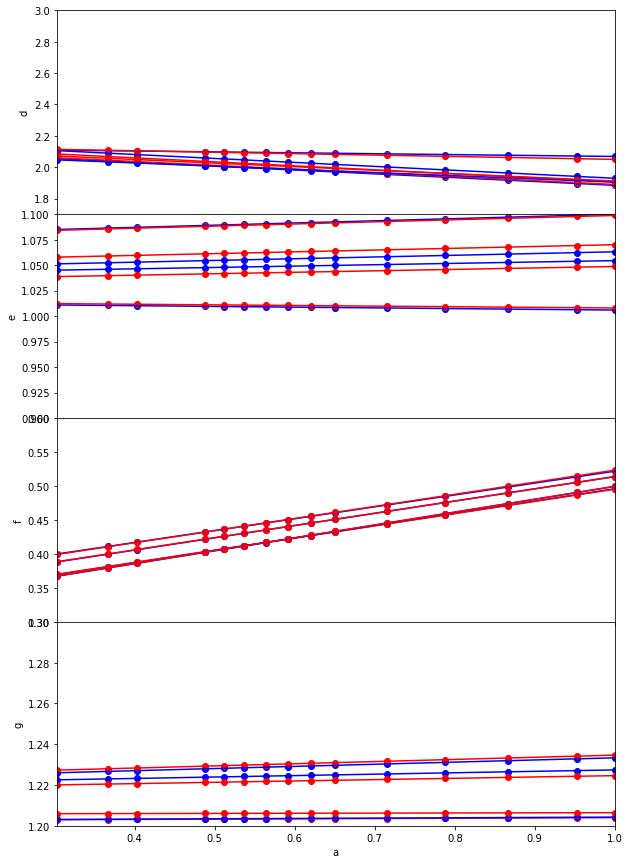

In [12]:

import matplotlib.pyplot as plt


fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(10,15), sharex=True)
wjat = ['Box_n50_0_1400', 'Box_n50_14_1400', 'Box_n50_33_1400', 'Box_n50_32_1400']
# wjat = [leave_out_box, 'Box98_1400']

# for box in [leave_out_box]:#, 'Box_n50_14_1400']:
# for box in [leave_out_box, 'Box98_1400', 'Box_n50_0_1400']:#, 'Box_n50_14_1400', 'Box_n50_33_1400', 'Box_n50_32_1400']:
for box in tqdm(wjat):
    curr_cosmo_vals = tuple(get_cosmo_vals(cosmo_params[box]))
    curr_ccl_cosmo = get_ccl_cosmology(curr_cosmo_vals)

    param_names = ['d','e','f','g']
    ndim = len(param_names)
    plt.subplots_adjust(wspace=0, hspace=0)

    params = {'d':[], 'e':[], 'f':[], 'g':[]}
    paramsEMU = {'d':[], 'e':[], 'f':[], 'g':[]}

    for a in a_list:
        R = 8 / (cosmo_params[box]['H0'] / 100)
        sigma8z = cosmo.sigmaR(R, a=a)
        EMU  = (Emulator.predict_params(cosmo_params[box], scaleToRedshift(a))) #, sigma8z))

        with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_params.pkl"%(box), "rb") as f:
            MLE_params = pickle.load(f)
            curr_params = list(MLE_params.values())
            paired_params = list(zip(curr_params, curr_params[1:]))[::2]

            param_at_z = {'d':-1, 'e':-1, 'f':-1, 'g':-1}

            for (p0,p1), key in zip(paired_params, param_at_z):
                param_at_z[key] = p(p0, p1, a)
            MLE_params = param_at_z

        for key in MLE_params:
            params[key] += [MLE_params[key]]
            paramsEMU[key] += [EMU[key]]


    for i, param in enumerate(params):
        aaaaa = 1
        axs[i].scatter(a_list, params[param], alpha=aaaaa, color='blue')
#         print(list(zip(a_list,params[param])))
#         print()
        axs[i].plot(a_list, params[param], alpha=aaaaa, color='blue')

        axs[i].scatter(a_list, paramsEMU[param], alpha=aaaaa, color='red')
        axs[i].plot(a_list, paramsEMU[param], alpha=aaaaa, color='red')

        axs[i].set_ylabel(param)
    #     axs[i].set_ylim([0,2])
        axs[i].set_xlim([min(a_list), 1])

axs[-1].set_xlabel('a')
# axs[0].set_ylim([0.25,.45])
# axs[1].set_ylim([0.29,.305])
# axs[2].set_ylim([1.4,1.8])
# axs[3].set_ylim([1.18, 1.2])
axs[0].set_ylim([1.7, 3.])
axs[1].set_ylim([0.9, 1.1])
axs[2].set_ylim([.3,.6])
axs[3].set_ylim([1.2,1.3])
# axs[0].set_title(box)

  7%|▋         | 1/15 [00:01<00:14,  1.03s/it]

[2.176431529399106, 0.9947063284226549, 0.5223997355637658, 1.2280946927125096]


 13%|█▎        | 2/15 [00:01<00:07,  1.66it/s]

[2.190227106666656, 0.9920465270726675, 0.5156211396973251, 1.2280959592632104]
[2.2005296230109606, 0.986518110986079, 0.5031044857752947, 1.2280968566552486]


 27%|██▋       | 4/15 [00:01<00:03,  3.21it/s]

[2.211171980720938, 0.9820675763910434, 0.49139515483724217, 1.2289712235285868]
[2.2482770614623844, 0.9784624758389601, 0.4790715004220306, 1.231343584988881]


 40%|████      | 6/15 [00:02<00:02,  4.39it/s]

[2.2726128262734786, 0.9749410619320034, 0.4687160116997149, 1.233116788121964]
[2.2855221364804215, 0.9731335523200331, 0.4632323803044346, 1.2341178305332958]


 53%|█████▎    | 8/15 [00:02<00:01,  4.78it/s]

[2.3030270543056606, 0.9716345435254987, 0.45818954495021014, 1.235391047930531]
[2.2981953662323304, 0.9699971918746875, 0.4546079273402134, 1.2353949291177413]


 67%|██████▋   | 10/15 [00:02<00:00,  5.02it/s]

[2.3024563434387693, 0.9680053623176561, 0.45096080991384957, 1.2353959905161211]


 80%|████████  | 12/15 [00:03<00:00,  5.39it/s]

[2.3252978201077408, 0.9657442920088855, 0.44519057151649805, 1.2353962483944603]
[2.328566015615783, 0.9642856469515912, 0.4417436166664215, 1.2353978417595846]


 87%|████████▋ | 13/15 [00:03<00:00,  5.55it/s]

[2.345129637693377, 0.9581935732533614, 0.4270860045138749, 1.235398661636454]


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]

[2.3812463962803223, 0.9542637373203032, 0.41742103814323583, 1.2353987371660835]
[2.359570419295517, 0.9521370129246526, 0.41326665811430197, 1.2354010962605466]


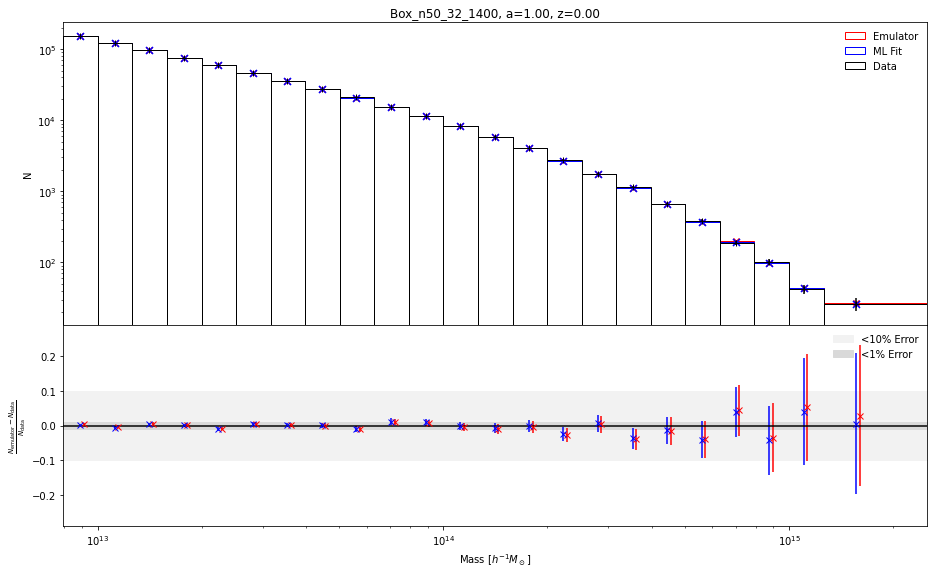

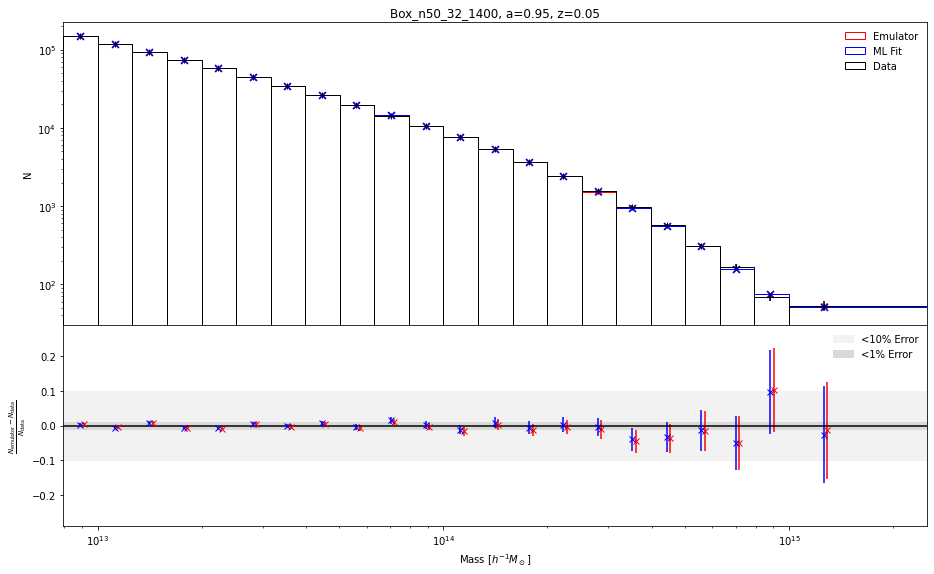

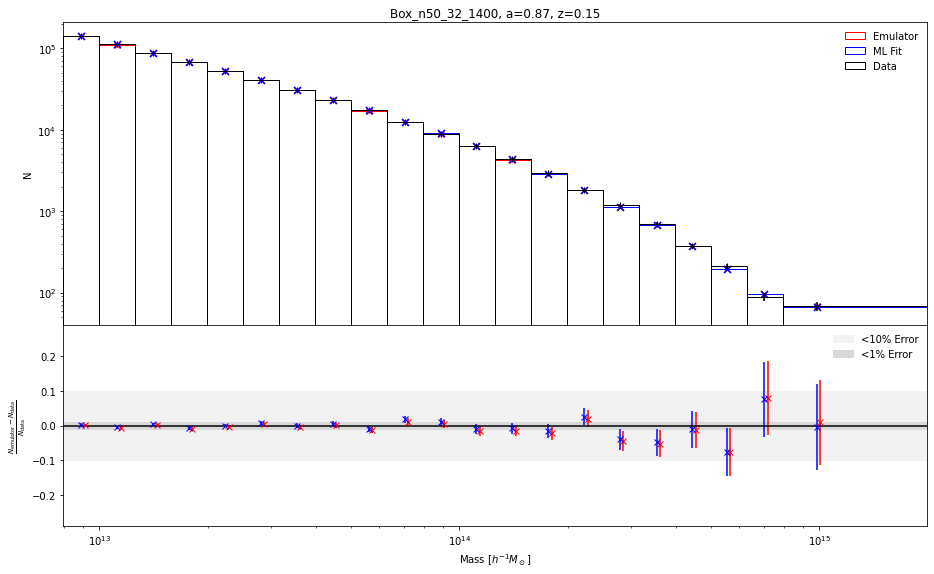

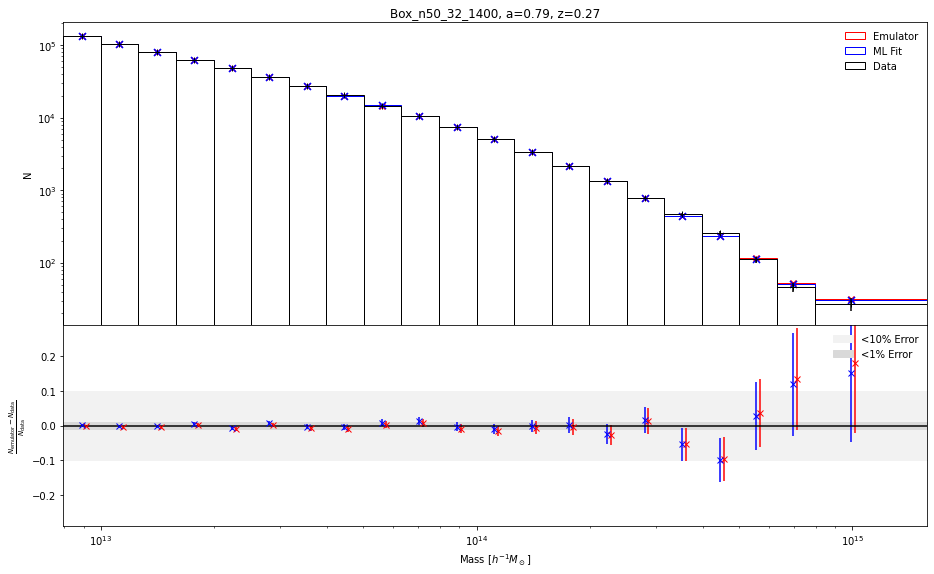

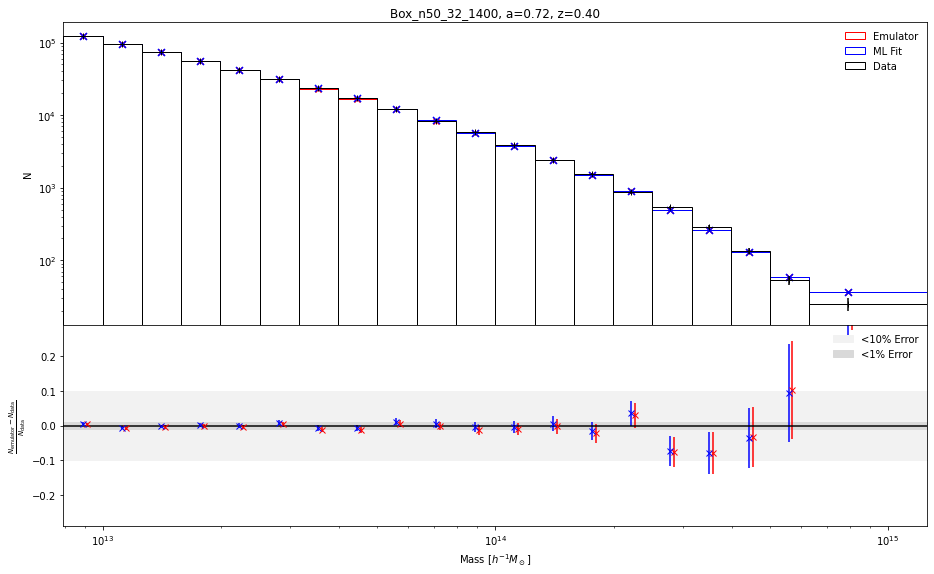

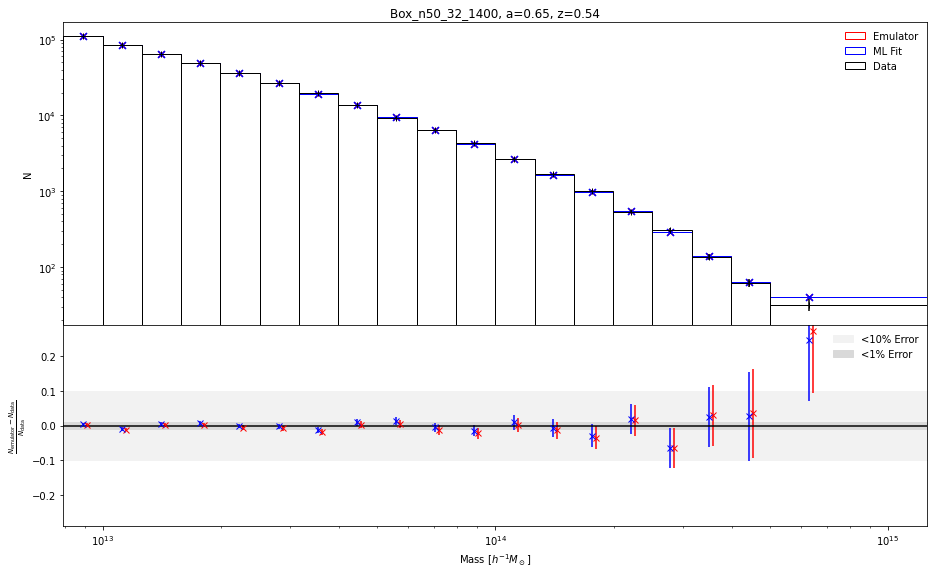

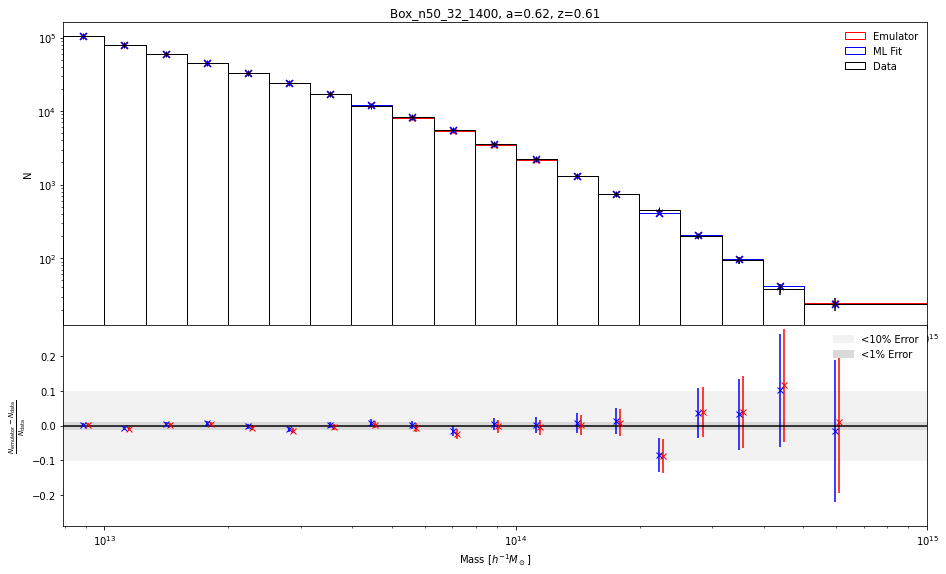

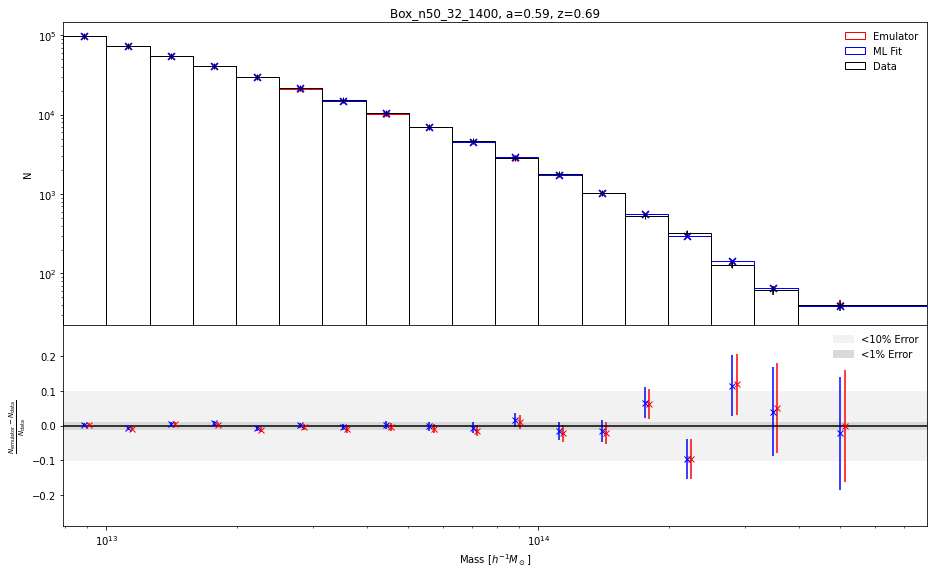

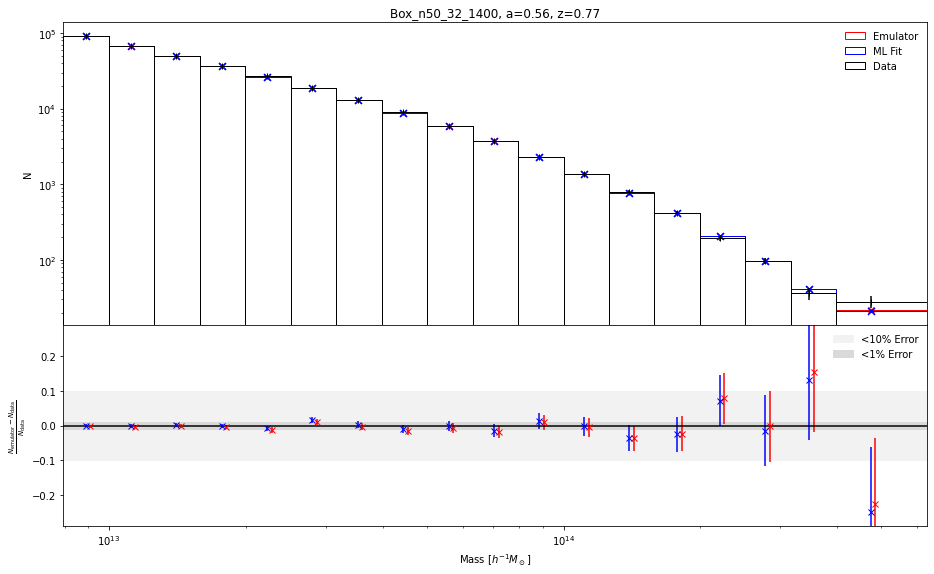

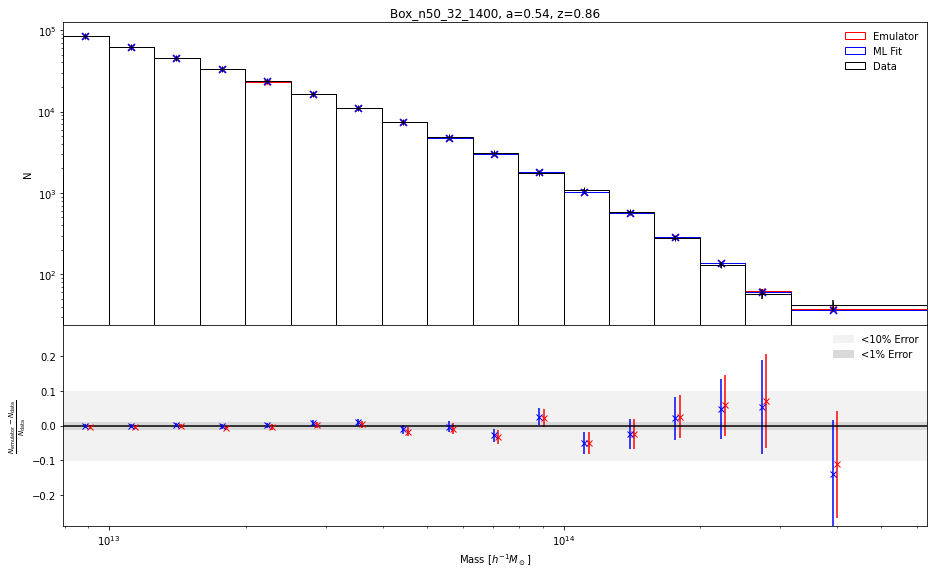

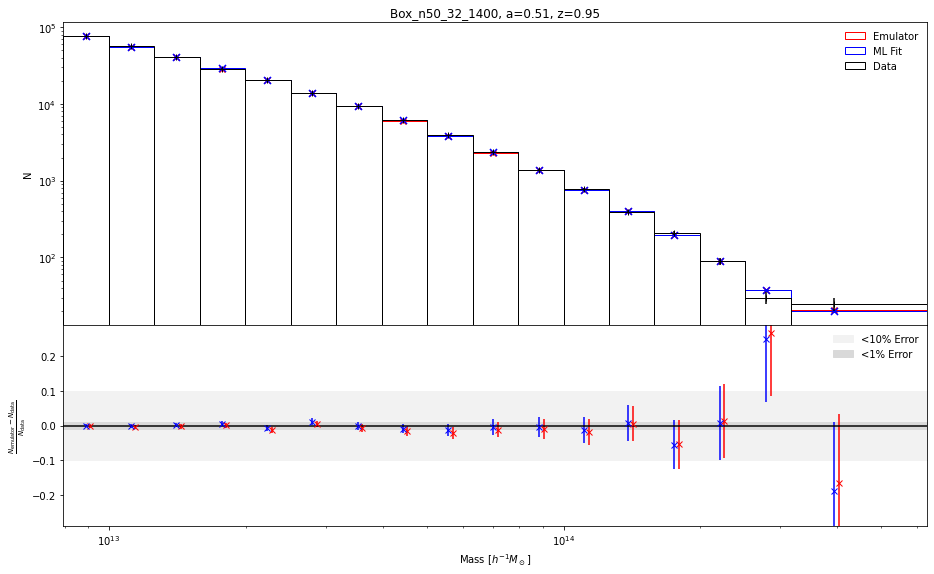

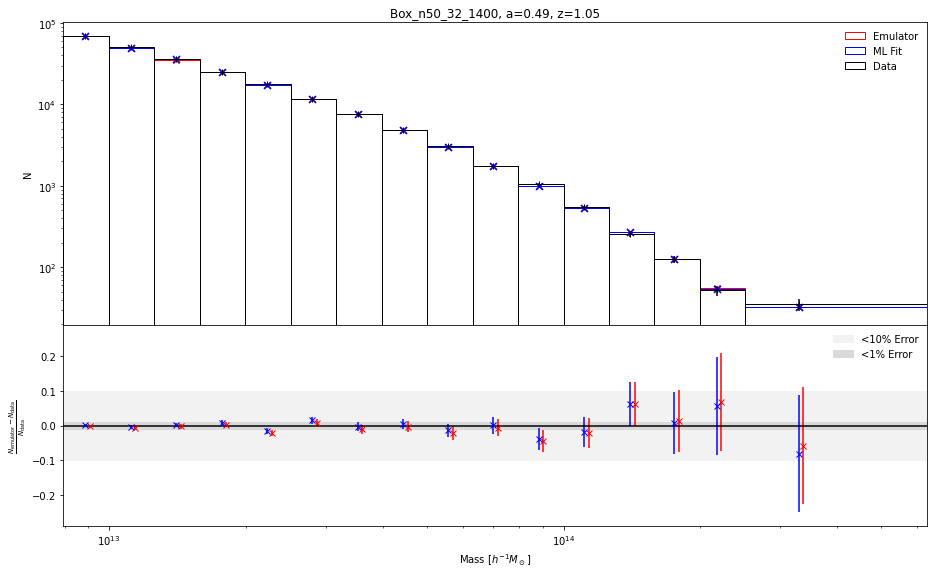

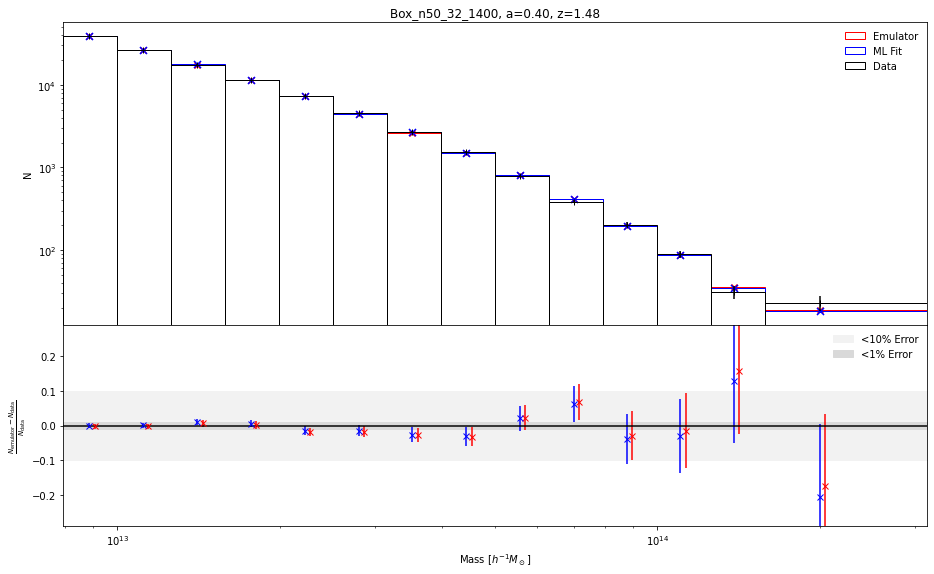

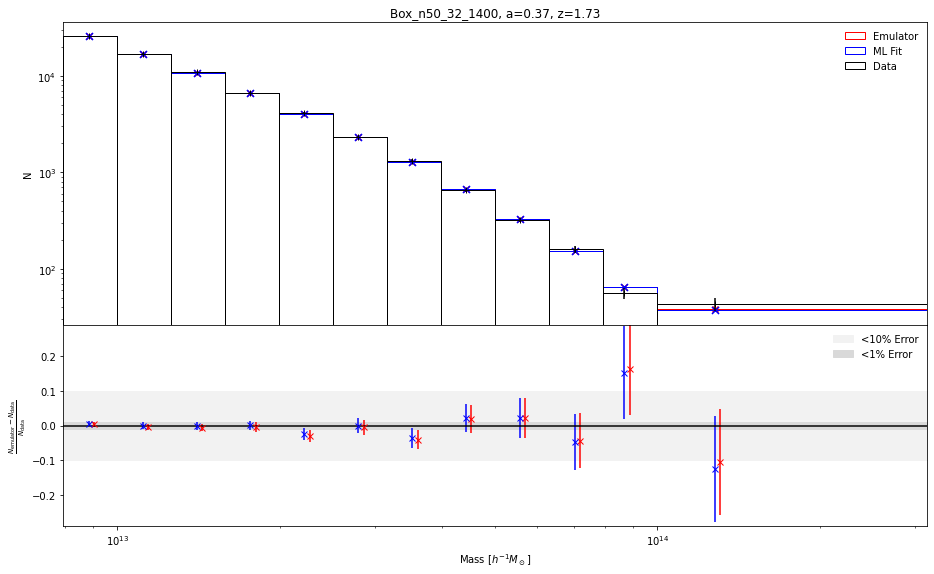

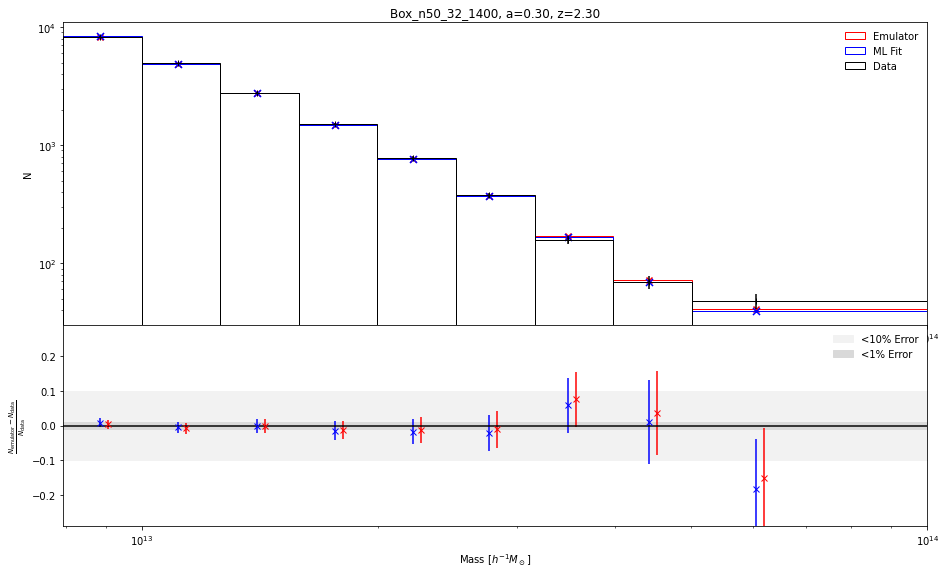

In [13]:
box = 'Box_n50_32_1400'

from aemulusnu_massfunction.massfunction import *

NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
NvM_f.close()

N_data = {}
M_data = {}
aux_data = {}

vol = -1 #Mpc^3/h^3
Mpart = -1

for a in tqdm(a_list):
#     if(a != 1): #TEST
#         continue
    c_data = NvMs[a]

    Ms = c_data['M'] #units of h^-1 Msolar
    N = c_data['N']
    edge_pairs = c_data['edge_pairs']
    assert(len(Ms) == len(edge_pairs))
    assert(len(Ms) == len(N))

    if(vol==-1):
        vol = c_data['vol']
    assert(vol == c_data['vol'])

    if(Mpart==-1):
        Mpart = c_data['Mpart']
    assert(Mpart == c_data['Mpart'])

    N_data[a] = []
    M_data[a] = []
    aux_data[a] = []
    for N_curr, M_curr, edge_pair in zip(N, Ms, edge_pairs):
        N_data[a] += [N_curr]
        M_data[a] += [M_curr]
        aux_data[a] += [{'a':a, 'edge_pair':edge_pair}]
M_numerics = np.logspace(np.log10(100*Mpart), 16, 50)

jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_jackknife_covs.pkl'
jackknife_covs_f = open(jackknife_covs_fname, 'rb')
jackknife = pickle.load(jackknife_covs_f)
jackknife_covs_f.close()

jack_covs = {a:jackknife[a][1] for a in N_data}

# Compute the weighted covariance matrix incorporating jackknife and poisson
weighted_cov = {a: jack_covs[a] for a in jack_covs}

param_names = ['d','e','f','g']


true_params = {}

ccl_cosmo = get_ccl_cosmology(tuple(get_cosmo_vals(cosmo_params[box])))

h = cosmo_params[box]['H0']/100


for a in tqdm(a_list):
    yerr = np.sqrt(np.diagonal(weighted_cov[a]))
    fig1 = plt.figure(figsize =(12, 7))

    axs=[fig1.add_axes((0.0,0.4,1,.6)), fig1.add_axes((0.0,0.0,1,.4))]
    plt.subplots_adjust(wspace=0, hspace=0)
    c_data = NvMs[a]

    Ms = M_data[a]
    N = N_data[a]
    edge_pairs = c_data['edge_pairs']

    edges = [edge[0] for edge in edge_pairs]
    edges += [edge_pairs[-1][1]]

    #shade in 1% and 10% error region
    edges = np.array(edges)
    
    

    y1 = 0.1*np.ones_like(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.1*np.ones_like(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    c_Ms = np.append(Ms, edges[-1])
    c_Ms = np.append(edges[0], c_Ms)
    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.95',label='<10% Error')

    y1 = 0.01*np.ones_like(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.01*np.ones_like(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.85',label='<1% Error')


    dM = np.array([edges[1]-edges[0] for edges in edge_pairs])


    #Emulator 
    f_dNdM_MCMC =  lambda M:Emulator(ccl_cosmo, M/h, a)*vol/(h**3 * M * np.log(10)) # h / Msun
    tinker_eval_MCMC = np.array([quad(f_dNdM_MCMC, edge[0],  edge[1], epsabs=0, epsrel=1e-5)[0] for edge in edge_pairs])

    axs[0].scatter(Ms, tinker_eval_MCMC, marker='x', c='red')
    axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges),
               align='edge', fill=False, ec='red', label='Emulator')
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_NvMemulator_loo_output.pkl"%(box, a), "wb") as f:
        pickle.dump({'Ms':Ms, 'tinker_eval':tinker_eval_MCMC, 'N':N, 'edges':edges}, f)

    tmp = np.array([c_tmp*10**(0.01)-c_tmp for c_tmp in Ms])
    axs[1].errorbar(Ms + tmp, (tinker_eval_MCMC-N)/N, yerr/N, fmt='x', color='red')

    #ML Fit

    mass_function = MassFuncAemulusNu_fitting()
    
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_params.pkl"%(box, a), "rb") as f:
        MLE_params = pickle.load(f)
        print(list(MLE_params.values()))
        mass_function.set_params(list(MLE_params.values()))


    f_dNdM_MCMC =  lambda M:mass_function(ccl_cosmo, M/h, a)*vol/(h**3 * M * np.log(10)) # h / Msun
    tinker_eval_MCMC = np.array([quad(f_dNdM_MCMC, edge[0],  edge[1], epsabs=0, epsrel=1e-5)[0] for edge in edge_pairs])
    axs[0].scatter(Ms, tinker_eval_MCMC, s=50 , marker='x', c='blue')
    axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges), 
               align='edge', fill=False, ec='blue', label='ML Fit')
    axs[1].errorbar(Ms, (tinker_eval_MCMC-N)/N, yerr/N, fmt='x', color='blue')



    #Data
    axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges),
           align='edge', fill=False, ec='black', label='Data')
    axs[0].errorbar(Ms, N, yerr, fmt='+', c='black')

    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].legend(frameon=False)
    axs[0].set_ylabel('N')

    axs[1].set_xscale('log')
    # axs[1].set_yscale('lin', linthresh=1e-2)    
    axs[1].legend(frameon=False)
    axs[1].axhline(0, c='black')
    axs[1].set_ylabel('N')
    axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
    axs[1].set_ylabel(r'$\frac{N_{\rm emulator}-N_{\rm data}}{N_{\rm data}} $')
    axs[0].set_title('%s, a=%.2f, z=%.2f'%(box, a, scaleToRedshift(a)))

    left = np.ceil(np.log10(200*Mpart) * 10) / 10
    axs[0].set_xlim((10**left, np.max(edges)))
    axs[1].set_xlim((10**left, np.max(edges)))
    axs[1].set_ylim((-.29, .29))
    axs[1].set_yticks([-.2, -.1, 0, .1, .2])

#     plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/emulator/%s_emufit_%.2f.pdf'%(box, a), bbox_inches='tight')